# AirBnB data project


## 1 Business Understanding
Host always wants to earn more money. The analysis answers the following questions:

 ###  How can you earn more as Airbnb host?
 +   There are three aspects for investors to increase their income. First, get the high rent of the house; secondly, increase the occupancy rate; thirdly, reduce the cost. We should answers the following three questions:
 #### how can we get high housing rent?
 #### how to improve the occupancy rate?
 #### how to save costs?


## 2 Data Understanding
It includes the following steps:
  -  Data gethering
  -  Data assessment

In order to get a better understanding of the data I will be looking at throughout this project, I will check the characteristics of the dataset. First, let's read in the data and necessary libraries.

In [154]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

### 2.1 Data Gethering
Kaggle provides the Airbnb Seattle datasets, I download them for the analysis.

In [2]:
calendar = pd.read_csv("./seattle/calendar.csv")
listings = pd.read_csv("./seattle/listings.csv")

### 2.2 Data assessment
  1. Get the number of rows and columns in this dataset.
      - 1) Get the shape 
      - 2) Get the data type and memory use
      - 3) Get rows example 
  2. Assess missing values distribution
      - 1) Get missing values distribution of columns/rows
      - 2) Get a set of column names that have no missing values.
      - 3) Get a set of column names that have more than target percents(e.g. 40%) if their values missing.
      - 4) Get a set of column names that have less than target percents if their values missing. They need to be imputed.
  3. Assess unique value for column. if it is unique value, the column can be removed.
  4. classify by actions : Get drop or imputation actions list based on classification after get colums list with unique vlaue. Get the following lists:
      - 1) drop columns list
      - 2) fullfill columns list
      - 3) imputation columns list
  4. Assess values distribution for object type.
      - 1) Check non-numeric columns
      - 2) Select columns to inspect further if columns are unclear in step 1.


In [3]:
def get_base_info(df):
    """
     The function is created to get the number of rows and columns in this dataset.
      - 1) Get the shape 
      - 2) Get the data type and memory use
      - 3) Get the rows example 
     Input:
        df: Dataframe, dataset 
     Return:
        NA
    """
    #Get the shape
    rows_num, columns_num=df.shape
    print( "The dataset contains {} rows and {} columns\n".format( rows_num,columns_num))
    
    #Get the data type and memory use
    if type(calendar) != pd.DataFrame:
        print("It is {},not a DataFrame. exit!".format(type(df)))
        return
    # Show all columns
    original_max_rows_setting= pd.options.display.max_rows
    pd.options.display.max_rows=columns_num
    df.info()
    # restore the orignal setting
    pd.options.display.max_rows=original_max_rows_setting
    
    # Get the rows example 
    show_rows(df)

def show_rows(df,n=5):
    #Get the shape
    rows_num, columns_num=df.shape
    # Show all columns
    original_max_rows_setting= pd.options.display.max_rows
    # Get the rows example 
    if pd.options.display.max_columns > columns_num:
        print("\nShow the dataset example:")
        print(df.head(n))
    else:
        print("\ncolum number is too large. Transpose the columns to show 3 rows")
        if pd.options.display.max_columns > columns_num:
            print( df.iloc[:3,:].T)
        else:
            pd.options.display.max_rows = columns_num
            print(pd.options.display.max_rows)
            print( df.iloc[:3,:].T)
            pd.options.display.max_rows = original_max_rows_setting

In [4]:
def assess_missing_value(df,drop_threshold=40):
    """
    Function description: Assess missing values distribution
      - 1) Get missing values distribution of columns/rows
      - 2) Get a set of column names that have no missing values.
      - 3) Get a set of column name that have more than target percents(e.g. 75%) if their values missing.
    Input:
        df: Dataframe, dataset 
    Return:
        full_cols_list: list, the columns lists has no misssing values.  
        most_missing_cols_list: list, the columns lists has  missing rate is greater than drop_threshold.  
        impute_cols_list: list, the columns lists has missing rate less than target percents if their values missing. 
                          They need to be imputed. 
    """
    #1) Get missing values distribution of columns and rows
    #  Check columns distribution
    bins=[0,5,10,15,20,25,30,40,50,60,70,80,100]
    df_missing_rate=df.isnull().mean()*100
    missing_col_cuts=pd.cut(df_missing_rate,bins)
    # set plot figure size
    plt.figure(figsize=(16,5))
    # set first subplot for columns
    plt.subplot(1,2,1)
    pd.value_counts(missing_col_cuts, sort=False).plot('bar', title="Columns distribution with missing value percentage")
    #  Check rows distribution
    # set second subplot for rows
    plt.subplot(1,2,2)
    df_missing_row=df.isnull().mean(axis=1)*100
    df_missing_row_cuts=pd.cut(df_missing_row,bins)
    pd.value_counts(df_missing_row_cuts, sort=False).plot('bar',title="Rows distribution with missing value percentage" )

    #2) Get a set of column names that have no missing values.
    # analyze missing data rate for columns in listings
    full_cols_list=df_missing_rate[df_missing_rate==0].index.values.tolist()
    
    #3) Get a set of column name that have more than target percents(e.g. 75%) if their values missing.
    most_missing_cols_list=df_missing_rate[df_missing_rate>drop_threshold].index.values.tolist()
    
    #4) Get a set of column names that have less than target percents if their values missing. They need to be imputed.
    impute_cols_list=df_missing_rate[((df_missing_rate<=drop_threshold)&(df_missing_rate>0))].index.values.tolist()
    
    return full_cols_list, most_missing_cols_list,impute_cols_list

def get_missing_rate(df,column_name):
    return df[column_name].isnull().mean()*100
    

In [5]:
def assess_unique_value(df):
    """
    Function description: 
        Assess unique value for column. if it is unique value, the column can be removed.
    Input:
        df: Dataframe, dataset 
    Return:
        unique_cols_list: list, the columns list that have unique value. It is useless in the analysis.    
    """
    # scan all columns, i is column position. Store value count in a colum
    value_count=[df.iloc[:,i].unique().size for i in range(df.shape[1])]
    # value_count = 1 : means unique value in a column. find out the column position  list and flatten to 1 D array.
    unique_col_id =np.argwhere(np.array(value_count) == 1).flatten()
    # get the columns list that have unique value
    unique_cols_list=df.iloc[:,unique_col_id].columns.values.tolist()
    return unique_cols_list

In [6]:
# The following functions are used for classifying by actions
def union_cols_list(list1,list2):
    return list(set(list1) | set(list2))
def intersection_cols_list(list1,list2):
    return list(set(list1) & set(list2))
def minus_cols_list(list1,list2):
    return list(set(list1) - set(list2))
def print_cols_list(list,action):
    print("\n{} {} columns are following:\n {}".format(len(list),action,list))
    
# if there is only one elememnt in list, convert the list to a value, or keep the list
flexiable_list= lambda x: x[0]if len(x)==1 else x

In [7]:
def check_nonnumeric_cols(df):
    """
    Function description: Check non-numeric columns. 
    Input:
        df: Dataframe, dataset 
    Return:
        nonnumeric_cols_list: list, the columns list whose type is nonnumeric. It may be category.  
    """
    # Get colum type is nonnumeric(string and others)
    cat_df=df.select_dtypes(include=['object'])
    show_rows(cat_df)
    nonnumeric_cols_list = cat_df.columns.values.tolist()
    return nonnumeric_cols_list

In [8]:
def assess_nonnumeric(df, column_name):
    """
    Function description: 
       Assess values distribution for Category type. if it is unique value, the column can be removed.
    Input:
        df: Dataframe, dataset 
        column_name: colum name to be assessed.
    Return:
        col_desc: pandas.DataFrame, the value distribution for the column.   
    """
    plt.figure(figsize=(12,5))
    value_dist =df[column_name].value_counts() # value_count can handle NaN value but seaborn cannot.
    value_dist=(value_dist/df.shape[0])
    value_dist.plot(kind="bar" );
    plt.title("values distribution of {} columns".format(column_name))
    
    # return statics info
    print("The number of missing value of {} columns is:{} ".format(column_name,df[column_name].isnull().sum()))
    print("The {} columns type is:{} ".format(column_name,df[column_name].dtypes))
    a = df[column_name].describe().reset_index()
    b = value_dist[:4].reset_index()
    c = value_dist[-4:].reset_index()
    col_desc=pd.concat([a,b])
    col_desc=pd.concat([col_desc,c])
    return col_desc

In [9]:
def check_numeric_cols(df):
    """
    Function description: Check numeric columns. 
    Input:
        df: Dataframe, dataset 
    Return:
        numeric_cols_list: list, the columns list whose type is nonnumeric. It may be category.  
    """
    # Get colum type is nonnumeric(string and others)
    num_df=df.select_dtypes(exclude=['object'])
    show_rows(num_df)
    numeric_cols_list = num_df.columns.values.tolist()
    return numeric_cols_list

In [10]:
def assess_full_numeric(df, num_full_cols_list):
    """
    Function description: 
       Assess values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:full numeric columns to be assessed.
    Return:
        NA   
    """
    #import pdb
    #pdb.set_trace()
    # calculate how many subplots and set figure size 
    count=len(num_full_cols_list)
    base_width=5
    base_high=4
    max_row_figures=4
    if count> max_row_figures:
        width= max_row_figures*base_width
        rows= count//max_row_figures+1
        high = base_high*rows
    else:
        width=count*base_width
        rows=1
        high =base_high
    # set figure size
    plt.figure(figsize=(width,high))
    i=1
    for col in num_full_cols_list:
        plt.subplot(max_row_figures,rows,i)
        i=i+1
        sns.distplot(df.loc[df[col].notnull(),[col]], label=col)
        plt.title('{} Distribution'.format(col))
        plt.legend();

In [11]:
def assess_full_numeric1(df, num_full_cols_list):
    """
    Function description: 
       Assess values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:numeric columns to be assessed.
    Return:
        NA   
    """
    for col in num_full_cols_list:
        plt.figure(figsize=(4,2))
        sns.distplot(df.loc[df[col].notnull(),[col]], label=col)
        plt.title('Distribution for numeric column: {}'.format(col))
        plt.legend();

In [12]:
check_nonnumeric_cols(calendar)


Show the dataset example:
         date available   price
0  2016-01-04         t  $85.00
1  2016-01-05         t  $85.00
2  2016-01-06         f     NaN
3  2016-01-07         f     NaN
4  2016-01-08         f     NaN


['date', 'available', 'price']

#### 2.2.1 Assess calendar dataset

In [13]:
get_base_info(calendar)

The dataset contains 1393570 rows and 4 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB

Show the dataset example:
   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN



3 no missing columns are following:
 ['listing_id', 'date', 'available']

0 most missing columns are following:
 []

1 imputing columns are following:
 ['price']


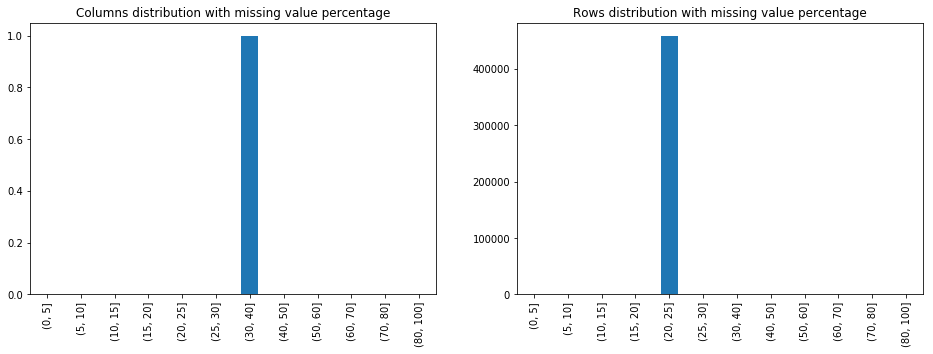

In [14]:
full_cols_c, most_missing_cols_c , impute_cols_c=assess_missing_value(calendar)
print_cols_list(full_cols_c,'no missing')
print_cols_list(most_missing_cols_c,'most missing')
print_cols_list(impute_cols_c,'imputing')

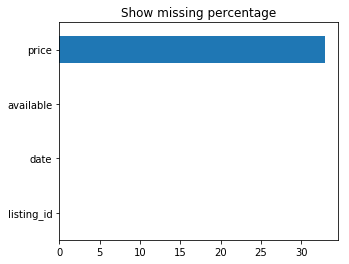

In [15]:
 #show missing percentage barh
(calendar.isnull().mean()*100).sort_values(ascending=True)[-30:].plot.barh(title="Show missing percentage",figsize=(5,4));

In [16]:
unique_cols_c=assess_unique_value(calendar)
print_cols_list(unique_cols_c,'unique')


0 unique columns are following:
 []


In [17]:
"""
classify by actions : Get drop or imputation actions list based on classification after get colums list with unique vlaue
    drop columns list 
    fullfill columns list
    imputation columns list
"""
all_cols_c_list=calendar.columns.values.tolist()
drop_cols_c=union_cols_list(most_missing_cols_c,unique_cols_c)
keep_cols_c=minus_cols_list(all_cols_c_list,drop_cols_c)
keep_full_cols_c=intersection_cols_list(keep_cols_c,full_cols_c)
keep_impute_cols_c=intersection_cols_list(keep_cols_c,impute_cols_c)

print_cols_list(drop_cols_c,'dropping')
print_cols_list(keep_full_cols_c,'no missing')
print_cols_list(keep_impute_cols_c,'imputing')


0 dropping columns are following:
 []

3 no missing columns are following:
 ['listing_id', 'available', 'date']

1 imputing columns are following:
 ['price']


In [18]:
print(get_missing_rate(calendar,'price'))

32.9389983998


In [19]:
pd.to_datetime(calendar['date']).describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

In [20]:
c_nonnumeric_cols_list=check_nonnumeric_cols(calendar)


Show the dataset example:
         date available   price
0  2016-01-04         t  $85.00
1  2016-01-05         t  $85.00
2  2016-01-06         f     NaN
3  2016-01-07         f     NaN
4  2016-01-08         f     NaN


In [21]:
a = calendar['available'].describe().reset_index()
b = calendar['available'].value_counts().reset_index()
c=pd.concat([a,b])
c

,index,available
0,count,1393570
1,unique,2
2,top,t
3,freq,934542
0,t,934542
1,f,459028


The number of missing value of available columns is:0 
The available columns type is:object 


,index,available
0,count,1393570
1,unique,2
2,top,t
3,freq,934542
0,t,0.67061
1,f,0.32939
0,t,0.67061
1,f,0.32939


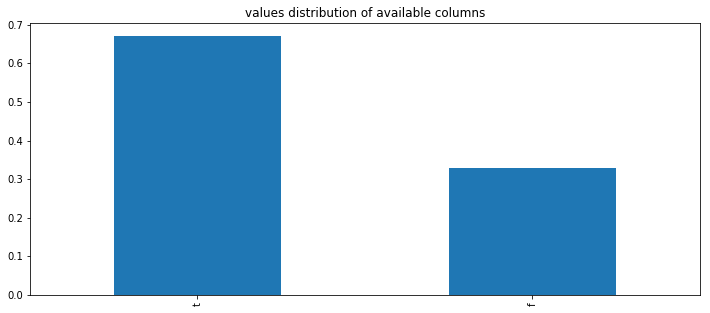

In [22]:
assess_nonnumeric(calendar,'available')

### Conclusion
 - No missing value columns: listing_id ,date ,available
      - data colum should be converted to datatime type.
      - available column should be convert to bool type.
 - Price column with about missing value. they miss value while available is false. the rows with missing price value can be set to 0. Special char e.g. '$ ,' should be removed. the column should be coverted to float type.

 

#### 2.2.2 Assess listings dataset

In [24]:
get_base_info(listings)

The dataset contains 3818 rows and 92 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null 


47 no missing columns are following:
 ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'experiences_offered', 'picture_url', 'host_id', 'host_url', 'host_verifications', 'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'room_type', 'accommodates', 'bed_type', 'amenities', 'price', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'requires_license', 'jurisdiction_names', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count']

6 most missing columns are following:
 ['notes', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'license']

39 

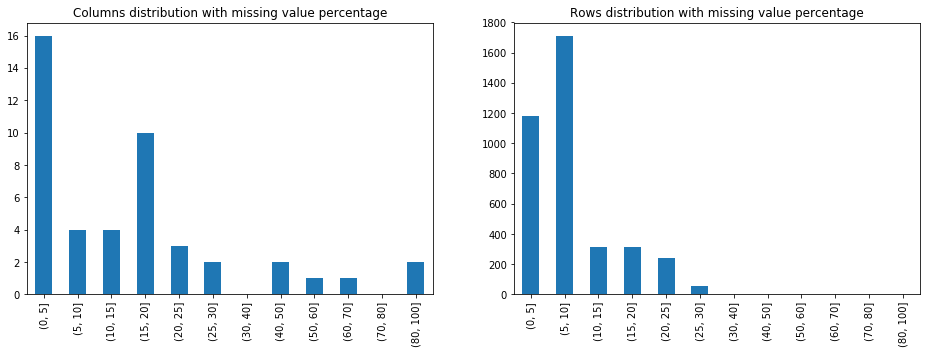

In [25]:
full_cols_l, most_missing_cols_l , impute_cols_l=assess_missing_value(listings)
print_cols_list(full_cols_l,'no missing')
print_cols_list(most_missing_cols_l,'most missing')
print_cols_list(impute_cols_l,'imputing')

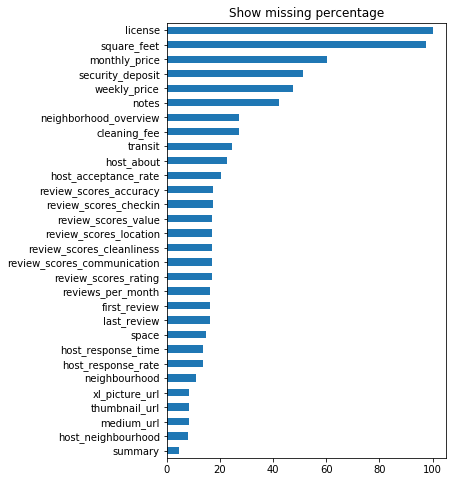

In [26]:
 #show missing percentage barh
(listings.isnull().mean()*100).sort_values(ascending=True)[-30:].plot.barh(title="Show missing percentage",figsize=(5,8));

In [27]:
unique_cols_l=assess_unique_value(listings)
print_cols_list(unique_cols_l,'unique')


11 unique columns are following:
 ['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']


In [28]:
"""
classify by actions : Get drop or imputation actions list based on classification after get colums list with unique vlaue
    drop columns list 
    fullfill columns list
    imputation columns list
"""
all_cols_l_list=listings.columns.values.tolist()
drop_cols_l=union_cols_list(most_missing_cols_l,unique_cols_l)
keep_cols_l=minus_cols_list(all_cols_l_list,drop_cols_l)
keep_full_cols_l=intersection_cols_list(keep_cols_l,full_cols_l)
keep_impute_cols_l=intersection_cols_list(keep_cols_l,impute_cols_l)

print_cols_list(drop_cols_l,'dropping')
print_cols_list(keep_full_cols_l,'no missing')
print_cols_list(keep_impute_cols_l,'imputing')


16 dropping columns are following:
 ['security_deposit', 'last_scraped', 'monthly_price', 'calendar_last_scraped', 'license', 'has_availability', 'scrape_id', 'notes', 'market', 'requires_license', 'country_code', 'jurisdiction_names', 'country', 'square_feet', 'experiences_offered', 'weekly_price']

37 no missing columns are following:
 ['cancellation_policy', 'instant_bookable', 'extra_people', 'availability_60', 'calculated_host_listings_count', 'price', 'description', 'city', 'room_type', 'listing_url', 'latitude', 'neighbourhood_group_cleansed', 'street', 'host_id', 'host_verifications', 'bed_type', 'maximum_nights', 'minimum_nights', 'id', 'guests_included', 'require_guest_profile_picture', 'longitude', 'calendar_updated', 'availability_30', 'state', 'accommodates', 'require_guest_phone_verification', 'neighbourhood_cleansed', 'amenities', 'picture_url', 'availability_365', 'name', 'is_location_exact', 'host_url', 'smart_location', 'availability_90', 'number_of_reviews']

39 imp

In [29]:
num_full_cols_list=check_numeric_cols(listings[keep_full_cols_l])
len(num_full_cols_list)


Show the dataset example:
   availability_60  calculated_host_listings_count   latitude   host_id  \
0               41                               2  47.636289    956883   
1               13                               6  47.639123   5177328   
2                6                               2  47.629724  16708587   
3                0                               1  47.638473   9851441   
4               60                               1  47.632918   1452570   

   maximum_nights  minimum_nights       id  guests_included   longitude  \
0             365               1   241032                2 -122.371025   
1              90               2   953595                1 -122.365666   
2              30               4  3308979               10 -122.369483   
3            1125               1  7421966                1 -122.369279   
4            1125               1   278830                6 -122.372471   

   availability_30  accommodates  availability_365  availability_90  \


14

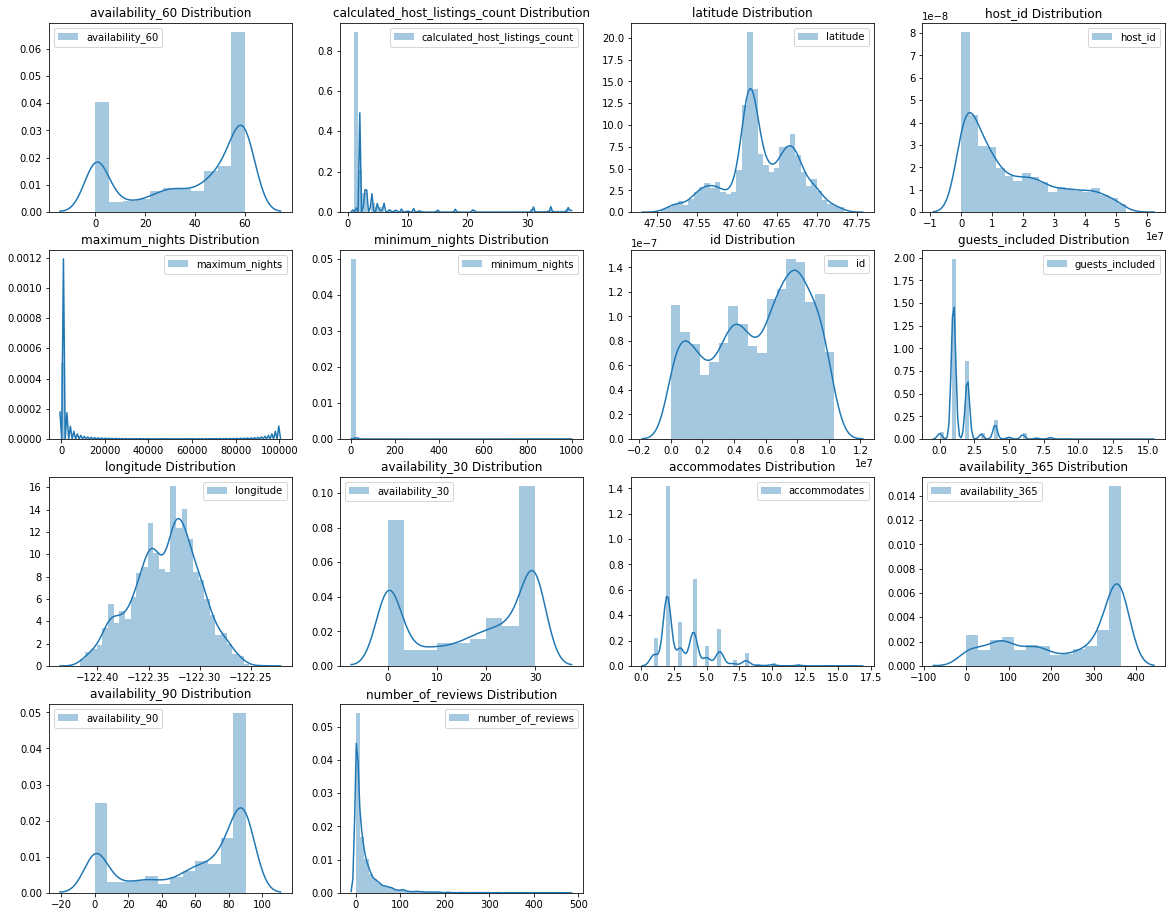

In [30]:
assess_full_numeric(listings,num_full_cols_list)

In [31]:
num_impute_cols_list=check_numeric_cols(listings[keep_impute_cols_l])
len(num_impute_cols_list)


Show the dataset example:
   review_scores_value  review_scores_accuracy  review_scores_communication  \
0                 10.0                    10.0                         10.0   
1                 10.0                    10.0                         10.0   
2                 10.0                    10.0                         10.0   
3                  NaN                     NaN                          NaN   
4                  9.0                     9.0                         10.0   

   review_scores_location  bedrooms  review_scores_checkin  \
0                     9.0       1.0                   10.0   
1                    10.0       1.0                   10.0   
2                    10.0       5.0                   10.0   
3                     NaN       0.0                    NaN   
4                     9.0       3.0                   10.0   

   review_scores_rating  review_scores_cleanliness  bathrooms  \
0                  95.0                       10.0        1.

13

In [32]:
l_nonnumeric_cols_list=check_nonnumeric_cols(listings[keep_full_cols_l])


colum number is too large. Transpose the columns to show 3 rows
23
                                                                                  0  \
cancellation_policy                                                        moderate   
instant_bookable                                                                  f   
extra_people                                                                  $5.00   
price                                                                        $85.00   
description                       Make your self at home in this charming one-be...   
city                                                                        Seattle   
room_type                                                           Entire home/apt   
listing_url                                     https://www.airbnb.com/rooms/241032   
neighbourhood_group_cleansed                                             Queen Anne   
street                                Gilman Dr W, Seattle, WA

In [33]:
(listings['require_guest_phone_verification']==listings['require_guest_profile_picture']).mean()*100

97.852278679937143

The number of missing value of is_location_exact columns is:0 
The is_location_exact columns type is:object 


,index,is_location_exact
0,count,3818
1,unique,2
2,top,t
3,freq,3412
0,t,0.893662
1,f,0.106338
0,t,0.893662
1,f,0.106338


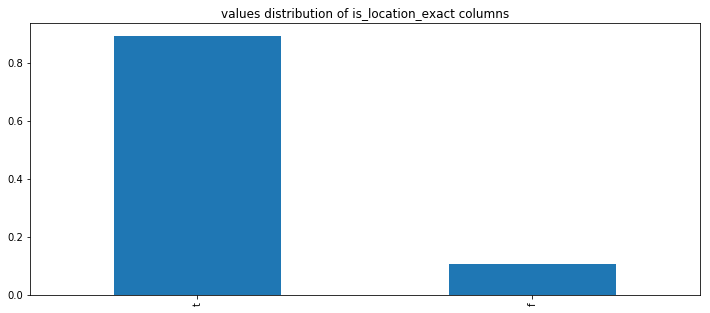

In [34]:
assess_nonnumeric(listings,'is_location_exact')

In [35]:
l_nonnumeric_impute_cols_list=check_nonnumeric_cols(listings[keep_impute_cols_l])


colum number is too large. Transpose the columns to show 3 rows
26
                                                                        0  \
medium_url                                                            NaN   
thumbnail_url                                                         NaN   
host_has_profile_pic                                                    t   
property_type                                                   Apartment   
summary                                                               NaN   
host_response_rate                                                    96%   
space                   Make your self at home in this charming one-be...   
host_name                                                           Maija   
transit                                                               NaN   
neighborhood_overview                                                 NaN   
host_response_time                                     within a few hours   
xl_pictu

The number of missing value of host_response_time columns is:523 
The host_response_time columns type is:object 


,index,host_response_time
0,count,3295
1,unique,4
2,top,within an hour
3,freq,1692
0,within an hour,0.443164
1,within a few hours,0.253536
2,within a day,0.156365
3,a few days or more,0.00995285
0,within an hour,0.443164
1,within a few hours,0.253536


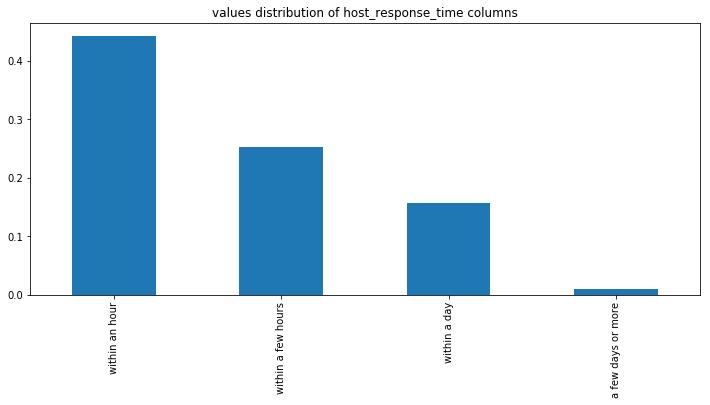

In [36]:
assess_nonnumeric(listings,'host_response_time')

The number of missing value of require_guest_profile_picture columns is:0 
The require_guest_profile_picture columns type is:object 


,index,require_guest_profile_picture
0,count,3818
1,unique,2
2,top,f
3,freq,3497
0,f,0.915925
1,t,0.0840754
0,f,0.915925
1,t,0.0840754


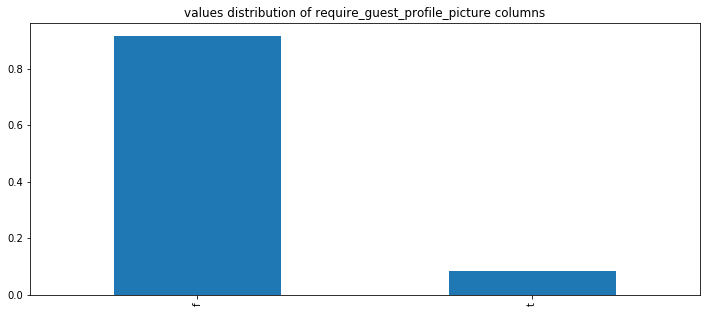

In [37]:
assess_nonnumeric(listings,'require_guest_profile_picture')

The number of missing value of property_type columns is:1 
The property_type columns type is:object 


,index,property_type
0,count,3817
1,unique,16
2,top,House
3,freq,1733
0,House,0.453903
1,Apartment,0.447355
2,Townhouse,0.0309062
3,Condominium,0.0238345
0,Treehouse,0.000785752
1,Chalet,0.000523834


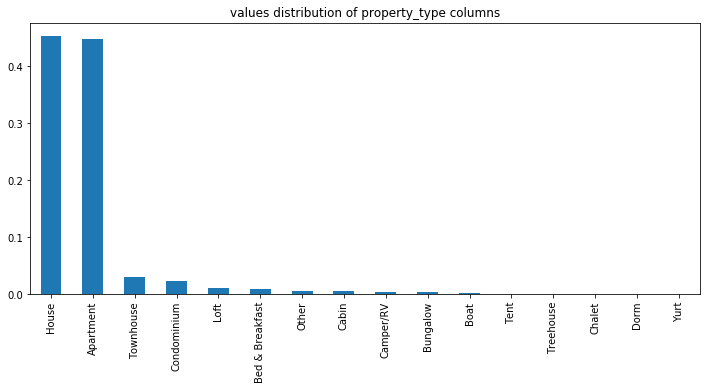

In [38]:
assess_nonnumeric(listings,'property_type')

In [39]:
listings['property_type'].isnull().mean()

0.00026191723415400735

The most important property_type are following. others can be skipped.
- House              0.453903
- Apartment          0.447355
- Townhouse          0.030906
- Condominium        0.023834
- Loft               0.010477

The number of missing value of calendar_updated columns is:0 
The calendar_updated columns type is:object 


,index,calendar_updated
0,count,3818
1,unique,34
2,top,today
3,freq,706
0,today,0.184914
1,2 weeks ago,0.0908853
2,3 weeks ago,0.0785752
3,2 months ago,0.0735987
0,17 months ago,0.000261917
1,14 months ago,0.000261917


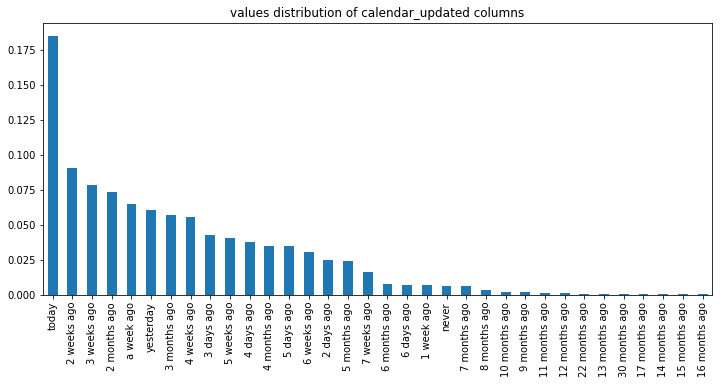

In [40]:
assess_nonnumeric(listings,'calendar_updated')

The number of missing value of room_type columns is:0 
The room_type columns type is:object 


,index,room_type
0,count,3818
1,unique,3
2,top,Entire home/apt
3,freq,2541
0,Entire home/apt,0.665532
1,Private room,0.303824
2,Shared room,0.0306443
0,Entire home/apt,0.665532
1,Private room,0.303824
2,Shared room,0.0306443


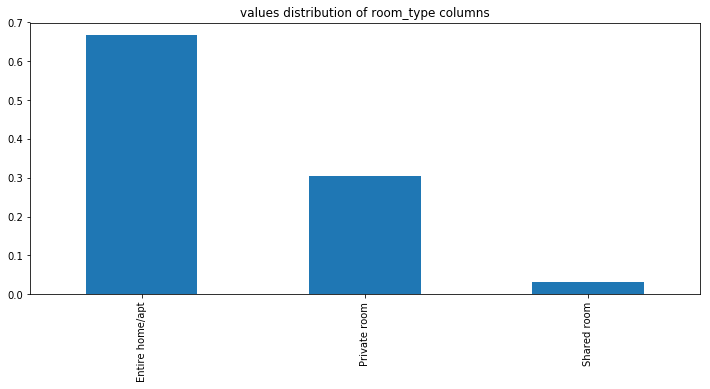

In [41]:
assess_nonnumeric(listings,'room_type')

The number of missing value of cancellation_policy columns is:0 
The cancellation_policy columns type is:object 


,index,cancellation_policy
0,count,3818
1,unique,3
2,top,strict
3,freq,1417
0,strict,0.371137
1,moderate,0.327658
2,flexible,0.301205
0,strict,0.371137
1,moderate,0.327658
2,flexible,0.301205


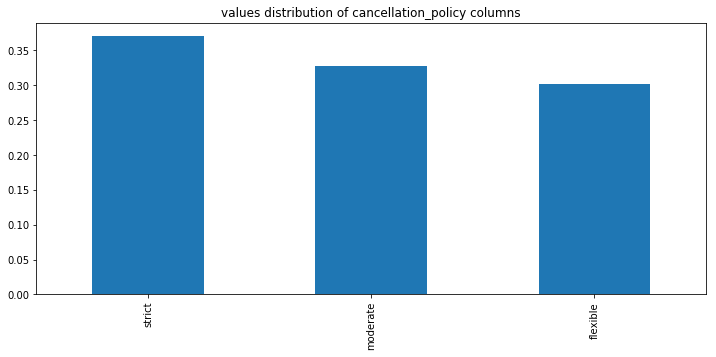

In [42]:
assess_nonnumeric(listings,'cancellation_policy')

The number of missing value of neighbourhood_group_cleansed columns is:0 
The neighbourhood_group_cleansed columns type is:object 


,index,neighbourhood_group_cleansed
0,count,3818
1,unique,17
2,top,Other neighborhoods
3,freq,794
0,Other neighborhoods,0.207962
1,Capitol Hill,0.148507
2,Downtown,0.138816
3,Central Area,0.0966475
0,Lake City,0.0175485
1,Magnolia,0.015977


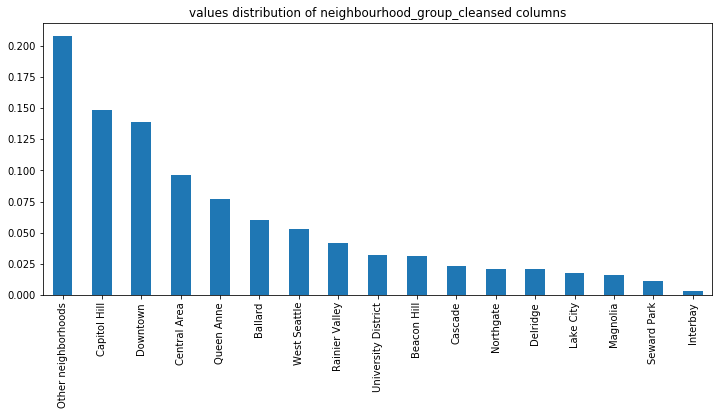

In [43]:
assess_nonnumeric(listings,'neighbourhood_group_cleansed')

The number of missing value of neighbourhood_cleansed columns is:0 
The neighbourhood_cleansed columns type is:object 


,index,neighbourhood_cleansed
0,count,3818
1,unique,87
2,top,Broadway
3,freq,397
0,Broadway,0.103981
1,Belltown,0.0612886
2,Wallingford,0.0437402
3,Fremont,0.0413829
0,South Beacon Hill,0.00104767
1,Pinehurst,0.00104767


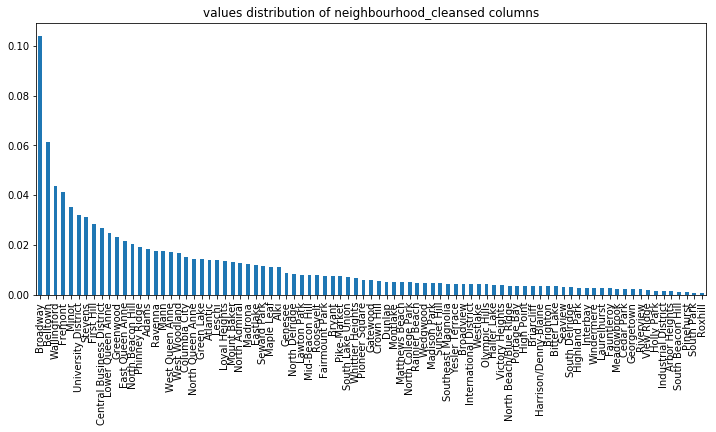

In [44]:
assess_nonnumeric(listings,'neighbourhood_cleansed')

The number of missing value of zipcode columns is:7 
The zipcode columns type is:object 


,index,zipcode
0,count,3811
1,unique,28
2,top,98122
3,freq,420
0,98122,0.110005
1,98103,0.103195
2,98102,0.0887899
3,98105,0.0589314
0,98178,0.00183342
1,98146,0.00130959


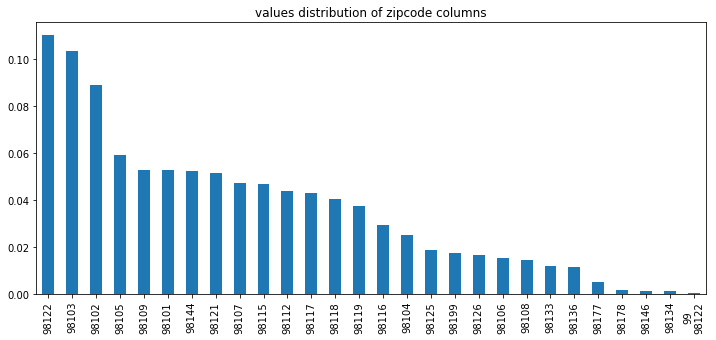

In [45]:
assess_nonnumeric(listings,'zipcode')

### Conclusion
 - The following 16 columns coming from 6 most Missing columns union 11 columns with unique value will be dropped.
     - ['security_deposit', 'last_scraped', 'market', 'license', 'has_availability', 'country_code', 'calendar_last_scraped', 'country', 'monthly_price', 'weekly_price', 'notes', 'requires_license', 'square_feet', 'jurisdiction_names', 'scrape_id', 'experiences_offered']
 - 37 no missing columns :(14 numeric columns, 23 nonnumeric columns), 23 nonnumeric columns are following:
     - 'smart_location','state','city' are also a column with unique value, because more thant 99% value is same. other value seem has the same meaning. so these columns will be removed.
     - 95% 'bed_type' is real bed, so I think it is a column with unique value. It can be dropped.
     - 'description','name' are descripsive columns, they can be dropped.
     - 'amenities' describes a basic configuration in room, they can be convert to amenities length. and it will be handled specially later.
     - 'neighbourhood_cleansed','street' will be dropped because other location colums provides similar information.
     - 'host_verifications' will be dropped because host_identity_verified provides same information.
     - 'require_guest_profile_picture' will be dropped because more thant 97.85% value is same as require_guest_phone_verification
     - 'calendar_updated'  will be dropped because review dataset provides similar information.
     - 'host_url','listing_url'and 'picture_url' will be dropped because they provide less predictive information.
     - 'is_location_exact','require_guest_phone_verification','instant_bookable' are bool type and need imputation.
     - 'neighbourhood_group_cleansed',	'room_type','cancellation_policy' are string/category type and need be converted to  dummies variable.

 - 39 imputing columns :(13 numeric columns, 26 nonnumeric columns), 26 nonnumeric columns are following:
      - 'summary' are  duplicated colum and can be dropped because they are decomposed into more specific features thereafter. 
      - 'host_about','host_picture_url','neighborhood_overview','transit','host_name','space','host_location', 'host_has_profile_pic'  are descripsive columns, they have little impact on predictions and can be ignored.
      - 'last_review','first_review' are 	duplication	information and can be ignored. Review dataset also includes them.
      - 'neighbourhood' are duplication	information and can be ignored.		other colums provides similar information.
      - 'host_neighbourhood','host_thumbnail_url','xl_picture_url' are less prediction. They provide less predictive information.
      - 'host_is_superhost','host_identity_verified' are bool type and need to be	imputed.
      - 'host_response_time' is category type and need to be	imputed.
      - 'host_response_rate','host_acceptance_rate' are numeric type and need to be imputed.
      - 'cleaning_fee' is numeric type and need to be imputed as most frequent value.
      - 'host_since' are numeric type and can be converted to years since beginning.
      - 'zipcode','property_type','host_response_time' are category type  and need to be	imputed. zipcode has invisible char and can be corrected. And proper_type has incorrect value(e.g. Bed & Breakfast), but the ratio is small and can be ignored.
      - 'medium_url','thumbnail_url' are category type and can be converted to  1 if value exit, or 0. it means airbnb are linked to social medium.

## 3 Data Preparation
 - Prepare lists for data clean
     - create column handling list based on data assessment.because these original columns shows as other types.
     - classify by types : verify data type based on classification
         - numeric columns list
         - datetime columns list
         - bool columns list
         - category columns list
 - Data Clean
     - drop columns or rows
     - handle data type of columns. Check if any columns are of different data types than you would expect ex: 
           - 1) numbers showing as strings
           - 2) String includes invisible char.
         
 - Select and Re-Encode Features
      
      Check the columns of the dataset. For numeric and interval data, these features can be kept without changes. Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (kept without any changes). Special handling may be necessary for the remaining two variable types: categorical, and 'mixed' columns.
 
     - Convert to target date type.
     - Re-Encode Categorical Features. Category columns get dummies. Depending on the number of categories, perform one of the following:
       - binary (two-level) categoricals with numeric values: do nothing.
       - binary variable with non-numeric values: re-encode the values as numbers or create a dummy variable.
       - Multi-level categoricals (three or more values): encode the values using multiple dummy variables or just drop them from the analysis. As always, document the choices in the Discussion section.
     - Engineer Mixed-Type Features
       - There are a handful of features that are marked as "mixed" columns in the dataset that require special treatment in order to be included in the analysis.
     - Complete Feature Selection.   To summarize, the dataframe should consist of the following:
       - All numeric, interval, and ordinal type columns from the original dataset.
       - Binary categorical features (all numerically-encoded).
       - Engineered features from other multi-level categorical features and mixed features.
     
 - Feature transforming
     - imputation columns
         1. use mean, mode, averge as imputation value.
         2. use ML prediction value as imputation value.
     - Make columns type clean that only inlcude basic type: int, float, string,list, dict, set.
     - Apply Feature Scaling
       - Normalize
       - Standardize
        

In [46]:
def initial_classify_types(df,drop_cols_list):
    """
    function description:
      Get the inital dtype columns.
    Input:
        df:Dateframe, the target dataframe.
        drop_cols_list: drop columns list based on value distribution.
    Return:
        result: dict={dtype:list}, get the initial information from dataset.
    """
    result={}
    dtype_dict={'datetime':'datetime','numeric':np.number,'bool':'bool','category':'object'}
    for k,v in dtype_dict.items():
         result[k]=df.select_dtypes(include=[v]).columns.values.tolist()
            
    # drop colum names also is removed from target after creating intial resut.
    for k, v in result.items():
        result[k]=minus_cols_list(result[k],drop_cols_list)   
    return result

In [47]:
def adjust_cols_list(df,assess_result,drop_cols_list): 
    """
    function description:
      classify by types : 
      - Get the inital dtype columns.
      - adjust dtype columns list based on the assessment result
    Input:
        assess_result:dict={dtype:list}, assessment result of dataset.
        drop_cols_list: drop columns list based on value distribution.
    Return:
        dtype_dict: dict={dtype:list},adjusted dtype dict based on the assessment result
    """
    # Get the inital dtype columns.
    dtypes_dict=initial_classify_types(df,drop_cols_list)
    # union for same data type, minus for diff data type
    for k, v in dtypes_dict.items():
        for ak,av in assess_result.items():
            if k == ak :
                dtypes_dict[k]=union_cols_list(dtypes_dict[k],assess_result[ak])
            elif ak !='drop':
                dtypes_dict[k]=minus_cols_list(dtypes_dict[k],assess_result[ak]) 
                
    # drop colum names also is removed from target after adjusting dtypes_dict.
    for k, v in dtypes_dict.items():
        dtypes_dict[k]=minus_cols_list(dtypes_dict[k],assess_result['drop'])
    
    # create the total drop columns list
    dtypes_dict['drop'] = assess_result['drop']+drop_cols_list
    # show result
    for k, v in dtypes_dict.items():
        print_cols_list(dtypes_dict[k],k)
   
    return dtypes_dict

In [48]:
"""
verify data type for columns
Check if any columns are of different data types than you would expect ex:
1) numbers showing as strings
2) String includes invisible char.
"""
def del_series_special_char(df_series, special_char,target_char=''):
    return df_series.str.replace(special_char,target_char) 

def del_df_special_char(df, special_char_string='$,'):
    """
    Function description:
      remove special char in object/string columns
    Input:
      df: Dataframe, dataset with only object/string columns.
      special_char_string:string, special char string. default is '$,'.
    Retrun:
      df:  Dataframe, dataset with only object/string columns after handling.
    """
    special_char_list=list(special_char_string)
    for col in df.columns.values.tolist():
        for s in special_char_list:
            df[col]= del_series_special_char(df[col], s)
    return df


### 3.1 Data Preparation for calendar
### calendar assessment conclusion
 - No missing value columns: listing_id ,date ,available
      - data colum should be converted to datatime type.
      - available column should be convert to bool type.
 - Price column with about missing value. they miss value while available is false. the rows with missing price value can be set to 0. Special char e.g. '$ ,' should be removed. the column should be coverted to float type.


#### 3.1.1 Prepare lists for data clean


In [49]:
# create column handling list based on data assessment. 
# because these original columns shows as other types.
assess_result_c={}
assess_result_c['drop']=[]
assess_result_c['datetime']=['date']
assess_result_c['numeric']=['price']
assess_result_c['bool']=['available']
assess_result_c['category']=[]
print(assess_result_c)

{'drop': [], 'category': [], 'numeric': ['price'], 'bool': ['available'], 'datetime': ['date']}


In [50]:
# adjust columns lists
dtypes_c_dict=adjust_cols_list(calendar,assess_result_c,drop_cols_c)


0 category columns are following:
 []

0 drop columns are following:
 []

2 numeric columns are following:
 ['price', 'listing_id']

1 bool columns are following:
 ['available']

1 datetime columns are following:
 ['date']


#### 3.1.2 data clean for calendar dataset
  - drop columns or rows
  - verify data type for columns. Check if any columns are of different data types than you would expect ex: 
     - 1) numbers showing as strings
     - 2) String includes invisible char.
         

##### 3.1.2.1 drop columns or rows

In [51]:
#remove drop colums from all columns and select them to clean dataset.
clean_calendar_cols = minus_cols_list(all_cols_c_list,dtypes_c_dict['drop'])
clean_calendar=calendar[clean_calendar_cols]

In [52]:
get_base_info(clean_calendar)

The dataset contains 1393570 rows and 4 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
price         934542 non-null object
date          1393570 non-null object
available     1393570 non-null object
listing_id    1393570 non-null int64
dtypes: int64(1), object(3)
memory usage: 42.5+ MB

Show the dataset example:
    price        date available  listing_id
0  $85.00  2016-01-04         t      241032
1  $85.00  2016-01-05         t      241032
2     NaN  2016-01-06         f      241032
3     NaN  2016-01-07         f      241032
4     NaN  2016-01-08         f      241032


##### 3.1.1.2 handle data type for columns

In [53]:
#numbers showing as strings
obj2num_c_list=assess_result_c['numeric']
clean_calendar[obj2num_c_list]=del_df_special_char(clean_calendar.loc[:,obj2num_c_list])
clean_calendar[obj2num_c_list].head()    

,price
0,85.00
1,85.00
2,NaN
3,NaN
4,NaN


The number of missing value of price columns is:459028 
The price columns type is:object 
    index        price
0   count       934542
1  unique          669
2     top       150.00
3    freq        36646
0  150.00    0.0262965
1  100.00    0.0227868
2   75.00    0.0213983
3  125.00    0.0197608
0  406.00  7.17581e-07
1  534.00  7.17581e-07
2  625.00  7.17581e-07
3  668.00  7.17581e-07


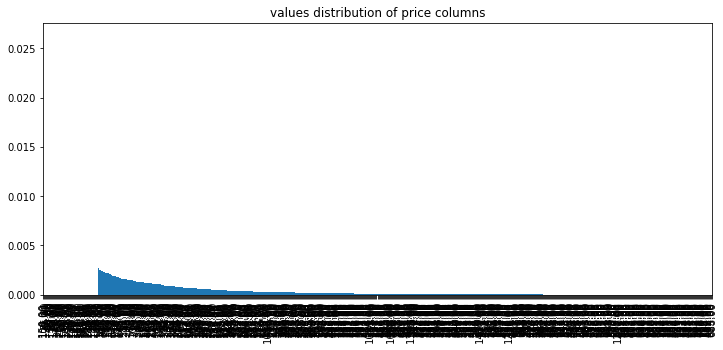

In [54]:
# check column value distribution.
for col in  obj2num_c_list:
    col_desc=assess_nonnumeric(clean_calendar,col)
    print(col_desc)

#### 3.1.3 Select and Re-Encode Features for calendar dataset
 - Select and Re-Encode Features
     - Convert columns type to target date type.
     - Re-Encode Categorical Features. Category columns get dummies. Depending on the number of categories, perform one of the following:
       - binary (two-level) categoricals with numeric values: do nothing.
       - binary variable with non-numeric values: re-encode the values as numbers or create a dummy variable.
       - Multi-level categoricals (three or more values): encode the values using multiple dummy variables or just drop them from the analysis. As always, document the choices in the Discussion section.
     - Engineer Mixed-Type Features
       - There are a handful of features that are marked as "mixed" columns in the dataset that require special treatment in order to be included in the analysis.
     - Complete Feature Selection.   To summarize, the dataframe should consist of the following:
       - All numeric, interval, and ordinal type columns from the original dataset.
       - Binary categorical features (all numerically-encoded).
       - Engineered features from other multi-level categorical features and mixed features.

##### 3.1.3.1 Convert columns type to target date type.

In [55]:
# convert date to datetime based on assesssment result.
for d in assess_result_c['datetime']:
    clean_calendar[d] = pd.to_datetime(clean_calendar[d])
clean_calendar[assess_result_c['datetime']].head()

,date
0,2016-01-04
1,2016-01-05
2,2016-01-06
3,2016-01-07
4,2016-01-08


In [56]:
clean_calendar[assess_result_c['datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 1 columns):
date    1393570 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 10.6 MB


##### 3.1.3.2 Re-Encode Categorical Features

The number of missing value of available columns is:0 
The available columns type is:object 
    index available
0   count   1393570
1  unique         2
2     top         t
3    freq    934542
0       t   0.67061
1       f   0.32939
0       t   0.67061
1       f   0.32939


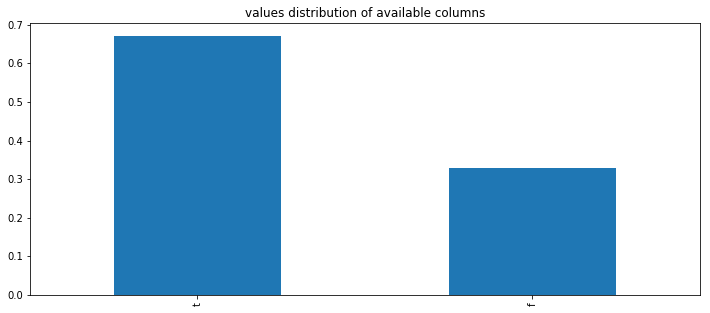

In [57]:
# binary variable with non-numeric values:convert available column to binary category

# check column value distribution.
for col in  dtypes_c_dict['bool']:
    col_desc=assess_nonnumeric(clean_calendar,col)
    print(col_desc)

In [58]:
# binary variable with non-numeric values:convert available column to binary category
mapping={'t':True,'f':False}
for col in dtypes_c_dict['bool']:
    clean_calendar[col]=clean_calendar[col].map(mapping)

clean_calendar[dtypes_c_dict['bool']].head()

,available
0,True
1,True
2,False
3,False
4,False


##### 3.1.3.3 Engineer Mixed-Type Features

In [59]:
#NO Mixed type features

#### 3.1.3.4 Complete Feature Selection. 

To summarize, the dataframe should consist of the following:
 - All numeric, interval, and ordinal type columns from the original dataset.
 - Binary categorical features (all numerically-encoded).
 - Engineered features from other multi-level categorical features and mixed features.

In [60]:
get_base_info(clean_calendar)

The dataset contains 1393570 rows and 4 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
price         934542 non-null object
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
listing_id    1393570 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 33.2+ MB

Show the dataset example:
   price       date  available  listing_id
0  85.00 2016-01-04       True      241032
1  85.00 2016-01-05       True      241032
2    NaN 2016-01-06      False      241032
3    NaN 2016-01-07      False      241032
4    NaN 2016-01-08      False      241032


#### 3.1.4 Feature transforming

  - imputation columns
         1. use mean, mode, averge as imputation value.
         2. use ML prediction value as imputation value.
  - Make columns type clean that only inlcude basic type: int, float, string,list, dict, set.
  - Apply Feature Scaling
    - Normalize
    - Standardize

##### 3.1.4.1  imputation columns
   1. use mean, mode, averge as imputation value.
   2. or use ML prediction value as imputation value.

In [61]:
# impute numeric column
num_cols_list=flexiable_list(dtypes_c_dict['numeric'])
clean_calendar[num_cols_list]=clean_calendar[num_cols_list].fillna(0)
clean_calendar[num_cols_list].head()

,price,listing_id
0,85.00,241032
1,85.00,241032
2,0,241032
3,0,241032
4,0,241032


In [62]:
clean_calendar['price']=clean_calendar['price'].astype(float)

In [63]:
get_base_info(clean_calendar)

The dataset contains 1393570 rows and 4 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
price         1393570 non-null float64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
listing_id    1393570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 33.2 MB

Show the dataset example:
   price       date  available  listing_id
0   85.0 2016-01-04       True      241032
1   85.0 2016-01-05       True      241032
2    0.0 2016-01-06      False      241032
3    0.0 2016-01-07      False      241032
4    0.0 2016-01-08      False      241032


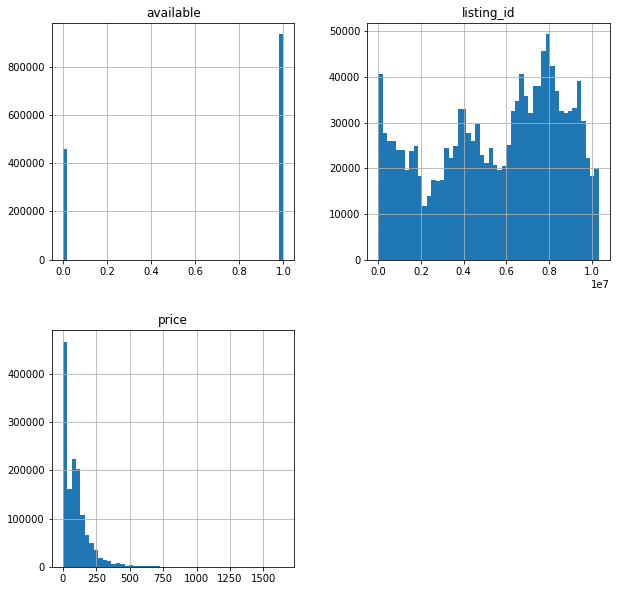

In [64]:
# check numeric columns distribution.
clean_calendar.select_dtypes(exclude=['datetime']).astype(float).hist(bins=50, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)
plt.show()

### 3.2 Data Preparation for listings dataset
#### 3.2.1 Prepare lists for data clean

In [65]:
# create column handling list based on data assessment. 
# because these original columns shows as other types.
assess_result_l={}
# drop columns in no missing part.
assess_result_l['drop']=['state','smart_location','host_url','listing_url','picture_url','host_verifications',
                         'description','name','city','neighbourhood_cleansed','street','bed_type','amenities',
                         'require_guest_profile_picture','calendar_updated'] 
assess_result_l['datetime']=[]
assess_result_l['bool']=['is_location_exact','require_guest_phone_verification','instant_bookable']
assess_result_l['numeric']=['price','extra_people','amenities_length']
assess_result_l['category']=['neighbourhood_group_cleansed','room_type','cancellation_policy']
# drop columns in imputation part.
assess_result_l['drop'] +=['summary','host_about','last_review','host_picture_url','host_neighbourhood',
                                'neighborhood_overview','transit','host_thumbnail_url','host_name','space','xl_picture_url',
                                'first_review','host_location','neighbourhood','host_has_profile_pic']
assess_result_l['bool'] +=['host_is_superhost','host_identity_verified','medium_url','thumbnail_url']
assess_result_l['numeric'] +=['cleaning_fee','host_response_rate','host_since','host_acceptance_rate']
assess_result_l['category'] +=['zipcode','property_type','host_response_time']
#print(assess_result_l)

In [66]:
#adjust dtype columns list based on the assessment result
dtypes_l_dict=adjust_cols_list(listings,assess_result_l,drop_cols_l)


6 category columns are following:
 ['cancellation_policy', 'neighbourhood_group_cleansed', 'zipcode', 'host_response_time', 'property_type', 'room_type']

46 drop columns are following:
 ['state', 'smart_location', 'host_url', 'listing_url', 'picture_url', 'host_verifications', 'description', 'name', 'city', 'neighbourhood_cleansed', 'street', 'bed_type', 'amenities', 'require_guest_profile_picture', 'calendar_updated', 'summary', 'host_about', 'last_review', 'host_picture_url', 'host_neighbourhood', 'neighborhood_overview', 'transit', 'host_thumbnail_url', 'host_name', 'space', 'xl_picture_url', 'first_review', 'host_location', 'neighbourhood', 'host_has_profile_pic', 'security_deposit', 'last_scraped', 'monthly_price', 'calendar_last_scraped', 'license', 'has_availability', 'scrape_id', 'notes', 'market', 'requires_license', 'country_code', 'jurisdiction_names', 'country', 'square_feet', 'experiences_offered', 'weekly_price']

34 numeric columns are following:
 ['review_scores_value

##### 3.2.1.1 drop columns or rows

In [67]:
#clean the drop columns or rows
if len(assess_result_l['drop']) > 0:
    clean_listings_cols = minus_cols_list(all_cols_l_list,dtypes_l_dict['drop'])
    clean_listings= listings.loc[:,clean_listings_cols]
#get_base_info(clean_listings)

##### 3.2.1.2 handle data type for columns
Check if any columns are of different data types than you would expect ex: 
     - 1) numbers showing as strings
     - 2) String includes invisible char.

In [68]:
# clean special string in numeric columns
# because host_since is a date type, need  convert to numeric. so removed it from numeric columns
obj2num_l_list=minus_cols_list(assess_result_l['numeric'] , ['host_since','amenities_length'])
clean_listings[obj2num_l_list]=del_df_special_char(clean_listings.loc[:,obj2num_l_list],'$,%')

In [69]:
get_base_info(clean_listings[obj2num_l_list])

The dataset contains 3818 rows and 5 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 5 columns):
host_response_rate      3295 non-null object
cleaning_fee            2788 non-null object
extra_people            3818 non-null object
price                   3818 non-null object
host_acceptance_rate    3045 non-null object
dtypes: object(5)
memory usage: 149.2+ KB

Show the dataset example:
  host_response_rate cleaning_fee extra_people   price host_acceptance_rate
0                 96          NaN         5.00   85.00                  100
1                 98        40.00         0.00  150.00                  100
2                 67       300.00        25.00  975.00                  100
3                NaN          NaN         0.00  100.00                  NaN
4                100       125.00        15.00  450.00                  NaN


In [70]:
# clear special char in zipcode column
clean_listings['zipcode']=clean_listings['zipcode'].str.replace('99\n98122','98122')

#### 3.2.3 Select and Re-Encode Features for listings dataset
 - Select and Re-Encode Features
     - Convert columns type to target date type.
     - Re-Encode Categorical Features. Category columns get dummies. Depending on the number of categories, perform one of the following:
       - binary (two-level) categoricals with numeric values: do nothing.
       - binary variable with non-numeric values: re-encode the values as numbers or create a dummy variable.
       - Multi-level categoricals (three or more values): encode the values using multiple dummy variables or just drop them from the analysis. As always, document the choices in the Discussion section.
     - Engineer Mixed-Type Features
       - There are a handful of features that are marked as "mixed" columns in the dataset that require special treatment in order to be included in the analysis.
     - Complete Feature Selection.   To summarize, the dataframe should consist of the following:
       - All numeric, interval, and ordinal type columns from the original dataset.
       - Binary categorical features (all numerically-encoded).
       - Engineered features from other multi-level categorical features and mixed features.

##### 3.2.3.1 Convert columns type to target date type.

###### handle 33 numeric columns :
 ['price', 'id', 'guests_included', 'accommodates', 'bathrooms', 'calculated_host_listings_count', 'host_acceptance_rate', 'review_scores_communication', 'cleaning_fee', 'availability_30', 'review_scores_cleanliness', 'review_scores_accuracy', 'reviews_per_month', 'review_scores_checkin', 'longitude', 'minimum_nights', 'review_scores_value', 'availability_365', 'bedrooms', 'latitude', 'host_response_rate', 'host_id', 'beds', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'extra_people', 'host_since', 'availability_90', 'host_listings_count', 'host_total_listings_count', 'review_scores_location', 'availability_60']

   - 'host_response_rate','host_acceptance_rate' are numeric type and need to be imputed.
   - 'cleaning_fee' is numeric type and need to be imputed as most frequent value.
   - 'host_since' are numeric type and can be converted to years since beginning.


In [72]:
# convert amenities to amenities's length based on assesssment result.
clean_listings['amenities_length']=listings['amenities'].apply(len)
clean_listings['amenities_length'].describe()

count    3818.000000
mean      200.060241
std        70.756117
min         2.000000
25%       155.000000
50%       198.000000
75%       245.000000
max       457.000000
Name: amenities_length, dtype: float64

In [73]:
# convert date to datetime based on assesssment result.
#Convert object to numeric.
obj2num_list_l=clean_listings[dtypes_l_dict['numeric']].select_dtypes(include=['object'])
print(obj2num_list_l.head())
print("\nassess numeric columnas result:\n {}".format(assess_result_l['numeric']))
print("\nAll numeric columns result:\n {}".format(dtypes_l_dict['numeric']))

  extra_people   price host_response_rate host_acceptance_rate  host_since  \
0         5.00   85.00                 96                  100  2011-08-11   
1         0.00  150.00                 98                  100  2013-02-21   
2        25.00  975.00                 67                  100  2014-06-12   
3         0.00  100.00                NaN                  NaN  2013-11-06   
4        15.00  450.00                100                  NaN  2011-11-29   

  cleaning_fee  
0          NaN  
1        40.00  
2       300.00  
3          NaN  
4       125.00  

assess numeric columnas result:
 ['price', 'extra_people', 'amenities_length', 'cleaning_fee', 'host_response_rate', 'host_since', 'host_acceptance_rate']

All numeric columns result:
 ['review_scores_value', 'extra_people', 'availability_60', 'calculated_host_listings_count', 'review_scores_communication', 'review_scores_accuracy', 'price', 'host_response_rate', 'latitude', 'review_scores_location', 'host_id', 'maximum_nigh

In [74]:
current_date=datetime(2017,1,2)
detal_days=lambda x: (current_date-x).days
clean_listings['host_since']=pd.to_datetime(clean_listings['host_since']).apply(detal_days)

In [75]:
print("Is there any missing value in the column? {}".format(clean_listings['host_since'].isnull().sum()))

Is there any missing value in the column? 2


In [76]:
clean_listings[assess_result_l['numeric']]=clean_listings[assess_result_l['numeric']].astype(float)
get_base_info(clean_listings[assess_result_l['numeric']])

The dataset contains 3818 rows and 7 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 7 columns):
price                   3818 non-null float64
extra_people            3818 non-null float64
amenities_length        3818 non-null float64
cleaning_fee            2788 non-null float64
host_response_rate      3295 non-null float64
host_since              3816 non-null float64
host_acceptance_rate    3045 non-null float64
dtypes: float64(7)
memory usage: 208.9 KB

Show the dataset example:
   price  extra_people  amenities_length  cleaning_fee  host_response_rate  \
0   85.0           5.0             114.0           NaN                96.0   
1  150.0           0.0             243.0          40.0                98.0   
2  975.0          25.0             291.0         300.0                67.0   
3  100.0           0.0             197.0           NaN                 NaN   
4  450.0          15.0             181.0         125.0             

##### 3.2.3.2 Re-Encode Categorical Features

##### handle bool columns:
 ['medium_url','thumbnail_url' , 'host_is_superhost', 'instant_bookable', 'is_location_exact', 'require_guest_phone_verification', 'host_identity_verified']
   - 'medium_url','thumbnail_url' are category type and can be converted to  1 if value exit, or 0. it means airbnb are linked to social medium.
   - 'is_location_exact','require_guest_phone_verification','instant_bookable' are bool type and need imputation.
   - 'host_is_superhost','host_identity_verified' are bool type and need to be	imputed.


In [77]:
# binary variable with non-numeric values:
#convert 'medium_url','thumbnail_url'  column to binary category
clean_listings[['medium_url','thumbnail_url']]=clean_listings[['medium_url','thumbnail_url']].notnull()

The number of missing value of medium_url columns is:0 
The medium_url columns type is:bool 
    index medium_url
0   count       3818
1  unique          2
2     top       True
3    freq       3498
0    True   0.916186
1   False  0.0838135
0    True   0.916186
1   False  0.0838135
The number of missing value of instant_bookable columns is:0 
The instant_bookable columns type is:object 
    index instant_bookable
0   count             3818
1  unique                2
2     top                f
3    freq             3227
0       f         0.845207
1       t         0.154793
0       f         0.845207
1       t         0.154793
The number of missing value of thumbnail_url columns is:0 
The thumbnail_url columns type is:bool 
    index thumbnail_url
0   count          3818
1  unique             2
2     top          True
3    freq          3498
0    True      0.916186
1   False     0.0838135
0    True      0.916186
1   False     0.0838135
The number of missing value of host_identity_verified

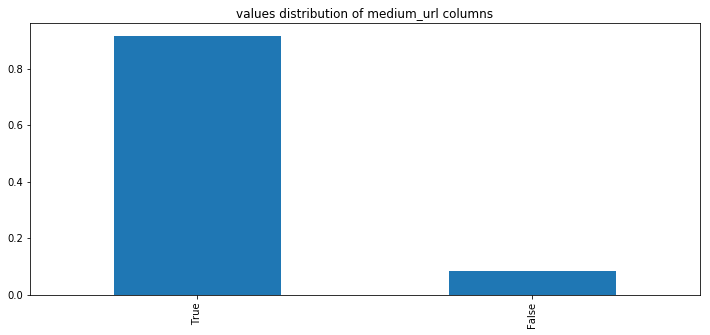

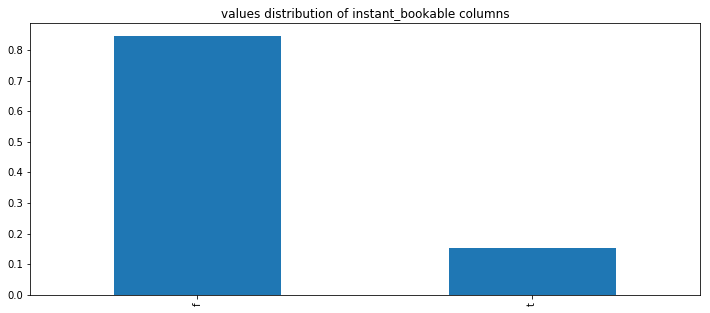

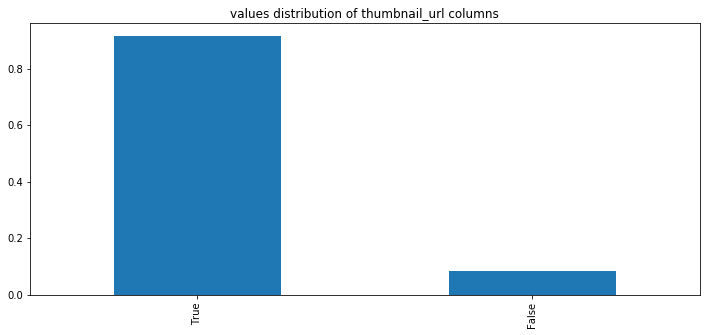

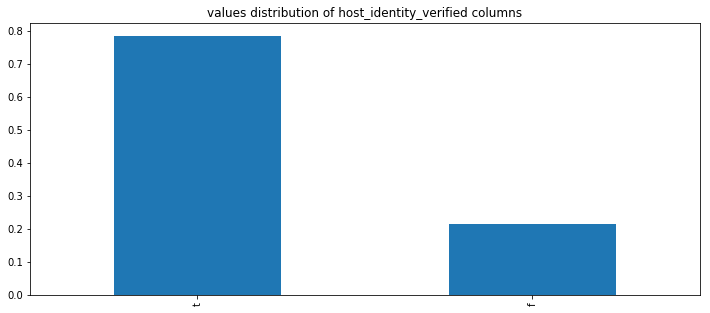

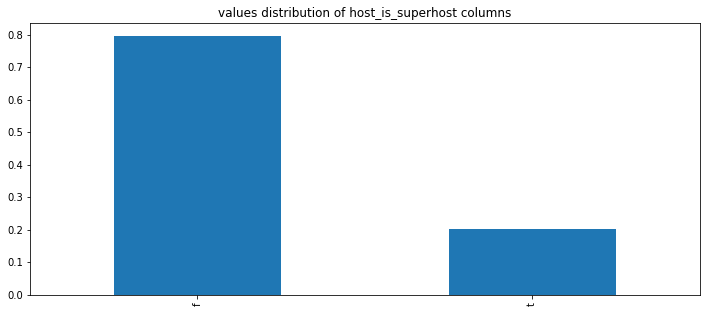

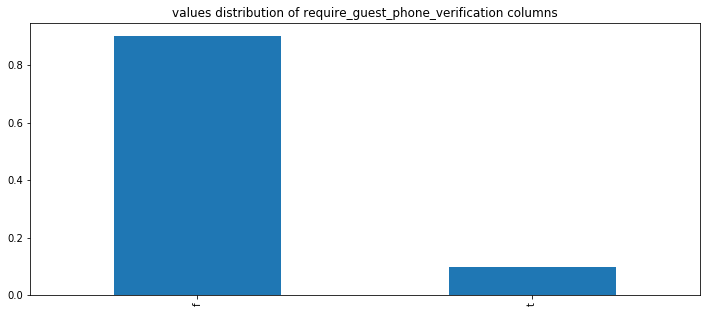

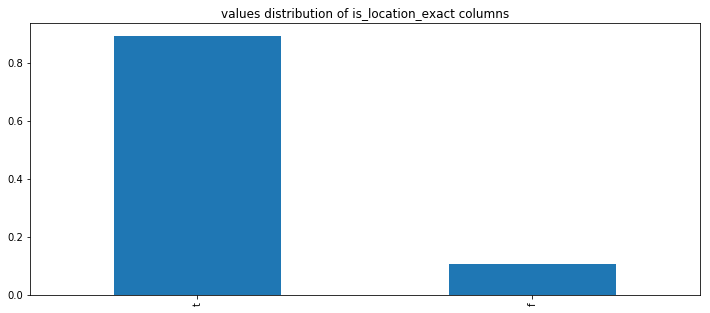

In [78]:
# check column value distribution.
for col in  dtypes_l_dict['bool']:
    col_desc=assess_nonnumeric(clean_listings,col)
    print(col_desc)

In [79]:
# binary variable with non-numeric values:convert available column to binary category
# clean_listings[bool_cols_l ]=clean_listings[bool_cols_l].applymap(mapping.get)
# clean bool columns. t=True, f=False
mapping={'t':True,'f':False}
for col in minus_cols_list(dtypes_l_dict['bool'],['medium_url','thumbnail_url']):
    clean_listings[col]=clean_listings[col].map(mapping)


In [80]:
clean_listings[assess_result_l['bool']]=clean_listings[assess_result_l['bool']].astype(bool)
clean_listings[assess_result_l['bool']].head()

,is_location_exact,require_guest_phone_verification,instant_bookable,host_is_superhost,host_identity_verified,medium_url,thumbnail_url
0,True,False,False,False,True,False,False
1,True,True,False,True,True,True,True
2,True,False,False,False,True,False,False
3,True,False,False,False,True,False,False
4,True,False,False,False,True,False,False


##### handle 8 category columns :
 ['cancellation_policy', 'zipcode', 'property_type', 'host_response_time', 'neighbourhood_group_cleansed', 'thumbnail_url', 'medium_url', 'room_type']
   - 'host_response_time' is category type and need to be	imputed.
   - 'neighbourhood_group_cleansed',	'room_type','cancellation_policy' are string/category type and need be converted to  dummies variable.
   - 'zipcode','property_type','host_response_time' are category type  and need to be	imputed. zipcode has invisible char and can be corrected. And proper_type has incorrect value(e.g. Bed & Breakfast), but the ratio is small and can be ignored.
   

In [81]:
clean_listings[dtypes_l_dict['category']].head()

,cancellation_policy,neighbourhood_group_cleansed,zipcode,host_response_time,property_type,room_type
0,moderate,Queen Anne,98119,within a few hours,Apartment,Entire home/apt
1,strict,Queen Anne,98119,within an hour,Apartment,Entire home/apt
2,strict,Queen Anne,98119,within a few hours,House,Entire home/apt
3,flexible,Queen Anne,98119,NaN,Apartment,Entire home/apt
4,strict,Queen Anne,98119,within an hour,House,Entire home/apt


In [82]:
clean_listings_dummy=pd.get_dummies(clean_listings[dtypes_l_dict['category']],dummy_na=True )

In [83]:
# remove oringal category columns 
clean_listings.drop(dtypes_l_dict['category'],inplace=True,axis=1)
# add category dummies
clean_listings = pd.concat([clean_listings,clean_listings_dummy],axis=1)
clean_listings.columns

Index(['medium_url', 'instant_bookable', 'thumbnail_url',
       'review_scores_value', 'extra_people', 'availability_60',
       'review_scores_accuracy', 'review_scores_communication',
       'calculated_host_listings_count', 'price',
       ...
       'property_type_Other', 'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt', 'property_type_nan',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'room_type_nan'],
      dtype='object', length=117)

##### 3.2.3.3 Engineer Mixed-Type Features

In [84]:
#No Mixed-Type columns

#### 3.2.3.4 Complete Feature Selection
To summarize, the dataframe should consist of the following:
 - All numeric, interval, and ordinal type columns from the original dataset.
 - Binary categorical features (all numerically-encoded).
 - Engineered features from other multi-level categorical features and mixed features.
 

In [85]:
get_base_info(clean_listings)

The dataset contains 3818 rows and 117 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 117 entries, medium_url to room_type_nan
dtypes: bool(7), float64(22), int64(12), uint8(76)
memory usage: 1.3 MB

colum number is too large. Transpose the columns to show 3 rows
117
                                                        0        1         2
medium_url                                          False     True     False
instant_bookable                                    False    False     False
thumbnail_url                                       False     True     False
review_scores_value                                    10       10        10
extra_people                                            5        0        25
availability_60                                        41       13         6
review_scores_accuracy                                 10       10        10
review_scores_communication                            10       10     

#### 3.2.4 Feature transforming

  - imputation columns
         1. use mean, mode, averge as imputation value.
         2. use ML prediction value as imputation value.
  - Make columns type clean that only inlcude basic type: int, float, string,list, dict, set.
  - Apply Feature Scaling
    - Normalize
    - Standardize

##### 3.2.4.1  imputation columns
   1. use mean, mode, averge as imputation value.
   2. or use ML prediction value as imputation value.
 

In [87]:
# impute missing value of cleaning_fee column with most frequent value
cleaning_fee_mode= clean_listings['cleaning_fee'].mode().values[0]
clean_listings['cleaning_fee'].fillna(cleaning_fee_mode, inplace=True)
clean_listings['cleaning_fee'].isnull().sum()

0

In [88]:
# impute missing value of bool column with most frequent value
for col in dtypes_l_dict['bool']:
    bool_mode = clean_listings[col].mode().values[0]
    clean_listings[col].fillna(bool_mode, inplace=True)

In [89]:
# impute numeric column.
before_imp_num_df=clean_listings[dtypes_l_dict['numeric']]
num_imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
np_num_imp=num_imp.fit_transform(before_imp_num_df.astype(np.float))
clean_listings_imp_num=pd.DataFrame(np_num_imp, columns=before_imp_num_df.columns)

In [90]:
# remove oringal numeric columns 
clean_listings.drop(dtypes_l_dict['numeric'],inplace=True,axis=1)
# add numeric dummies
clean_listings = pd.concat([clean_listings,clean_listings_imp_num],axis=1)

In [91]:
sorted(clean_listings.columns.values.tolist())

['accommodates',
 'amenities_length',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_nan',
 'cancellation_policy_strict',
 'cleaning_fee',
 'extra_people',
 'guests_included',
 'host_acceptance_rate',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_response_rate',
 'host_response_time_a few days or more',
 'host_response_time_nan',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_since',
 'host_total_listings_count',
 'id',
 'instant_bookable',
 'is_location_exact',
 'latitude',
 'longitude',
 'maximum_nights',
 'medium_url',
 'minimum_nights',
 'neighbourhood_group_cleansed_Ballard',
 'neighbourhood_group_cleansed_Beacon Hill',
 'neighbourhood_group_cleansed_Capitol Hill',
 'neig

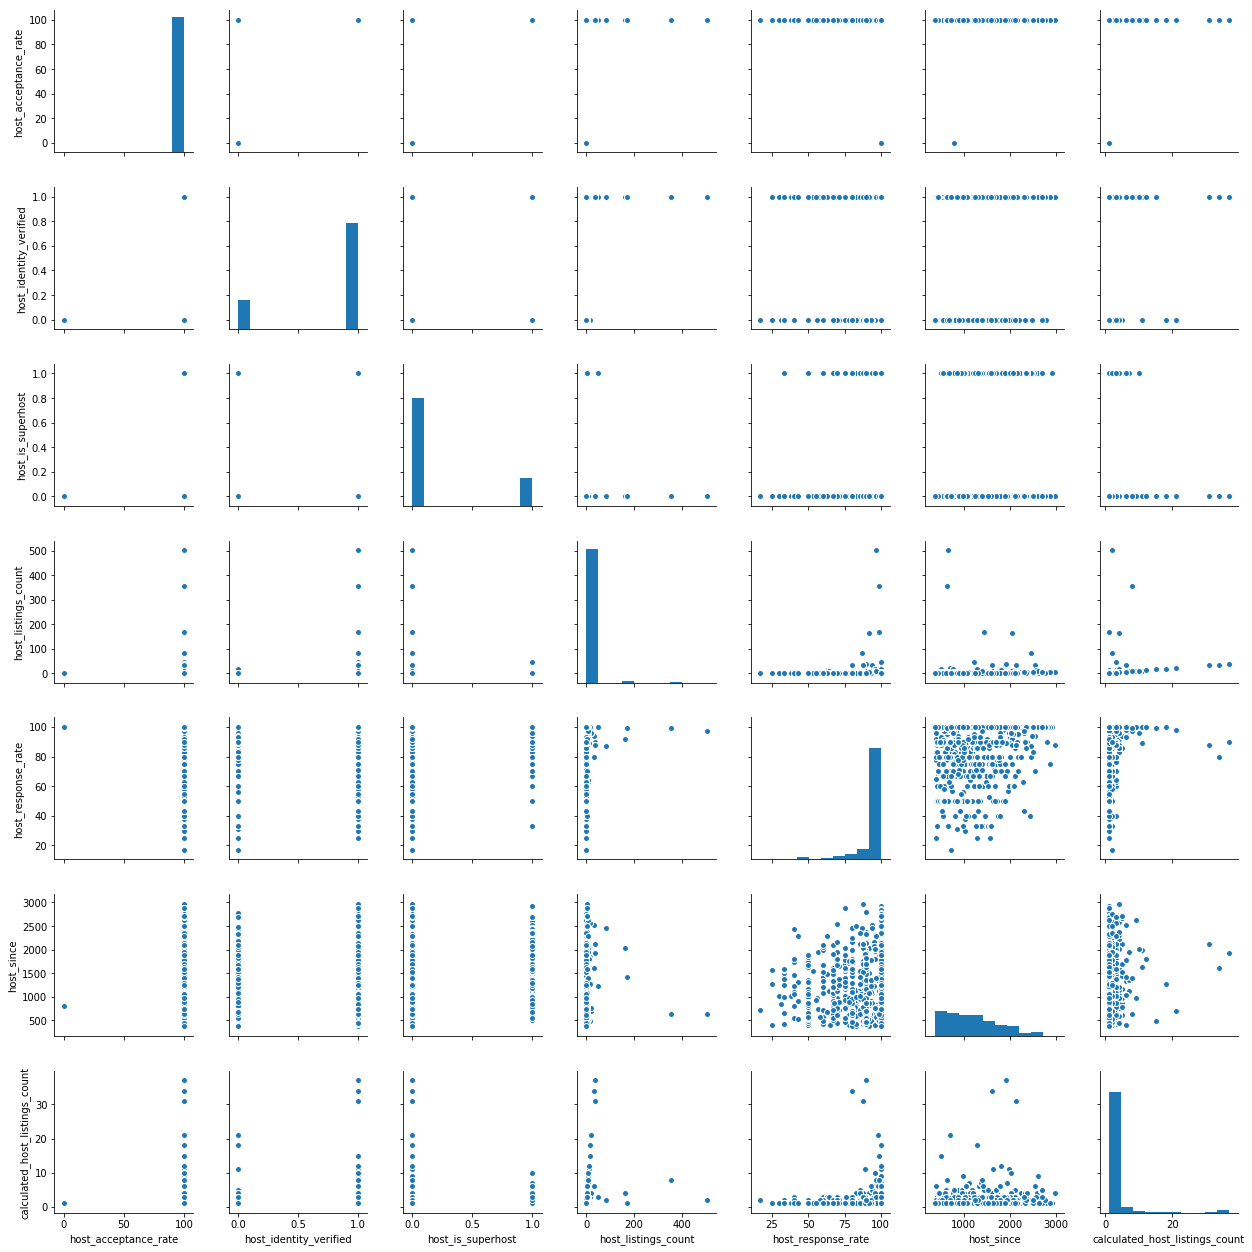

In [92]:
host_info_list= ['host_acceptance_rate',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_response_rate',
 'host_since',
 'calculated_host_listings_count']
clean_listings_num_host= clean_listings[host_info_list]
sns.pairplot(clean_listings_num_host);

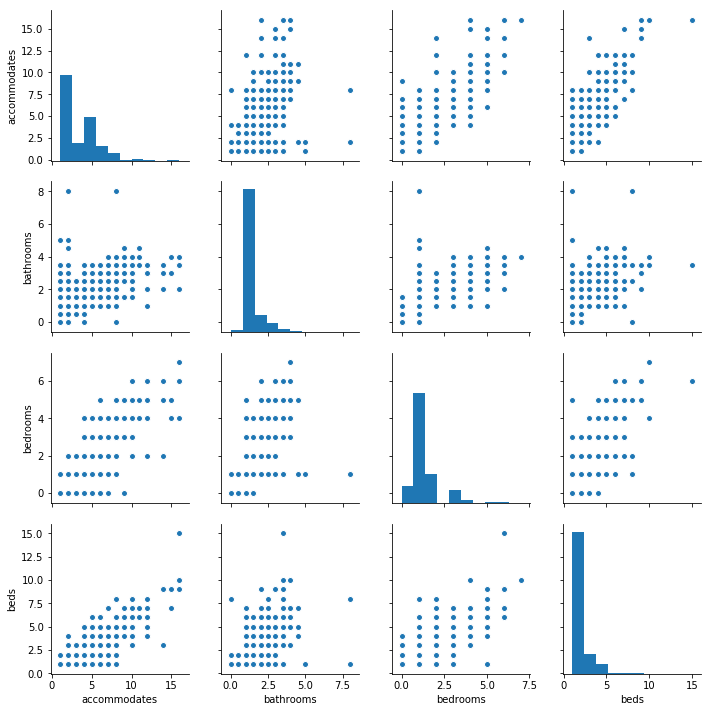

In [93]:
room_info_list=['accommodates',
 'bathrooms',
 'bedrooms',
 'beds' ]
sns.pairplot(clean_listings[room_info_list]);

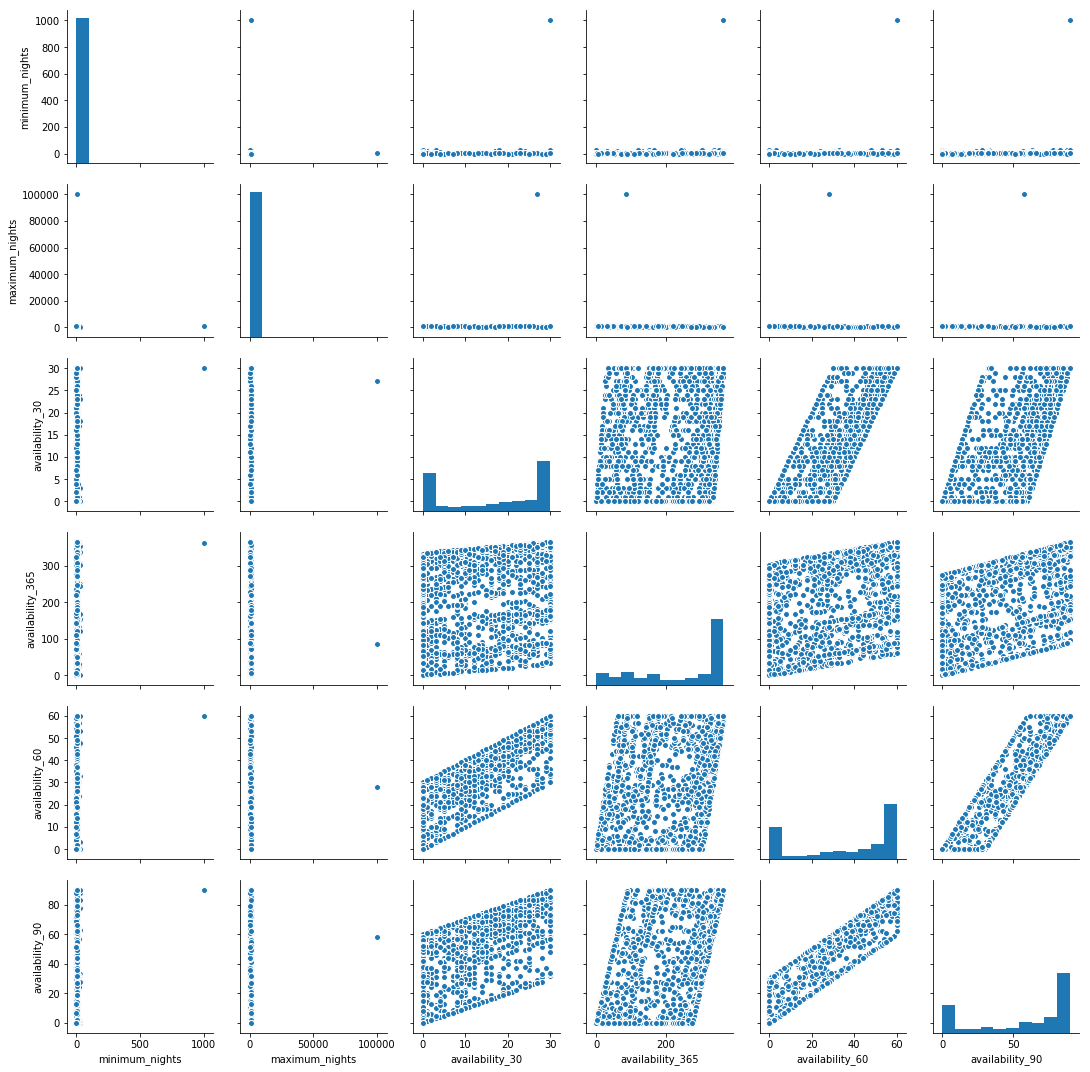

In [94]:
avail_info_list=[
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90']
sns.pairplot(clean_listings[avail_info_list]);

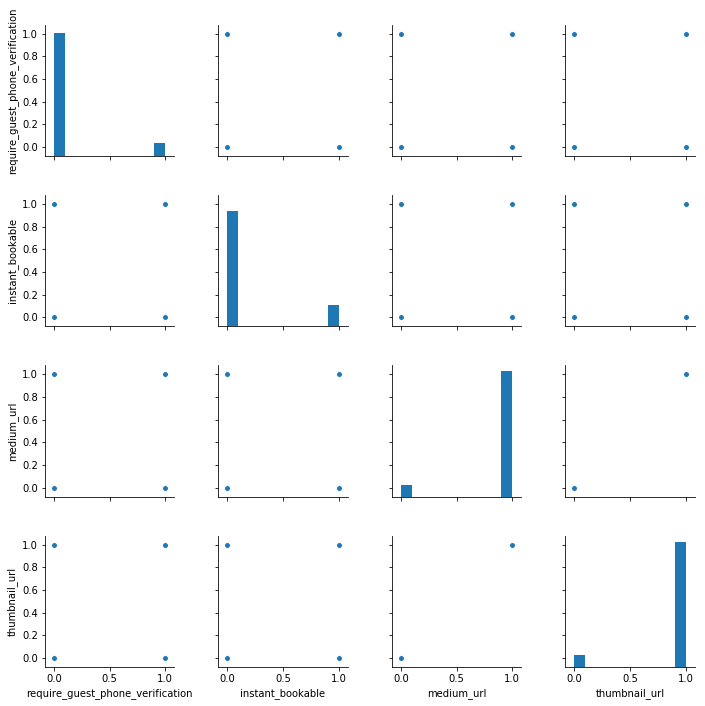

In [95]:
sns.pairplot(clean_listings[ [ 'require_guest_phone_verification','instant_bookable','medium_url', 'thumbnail_url']]);

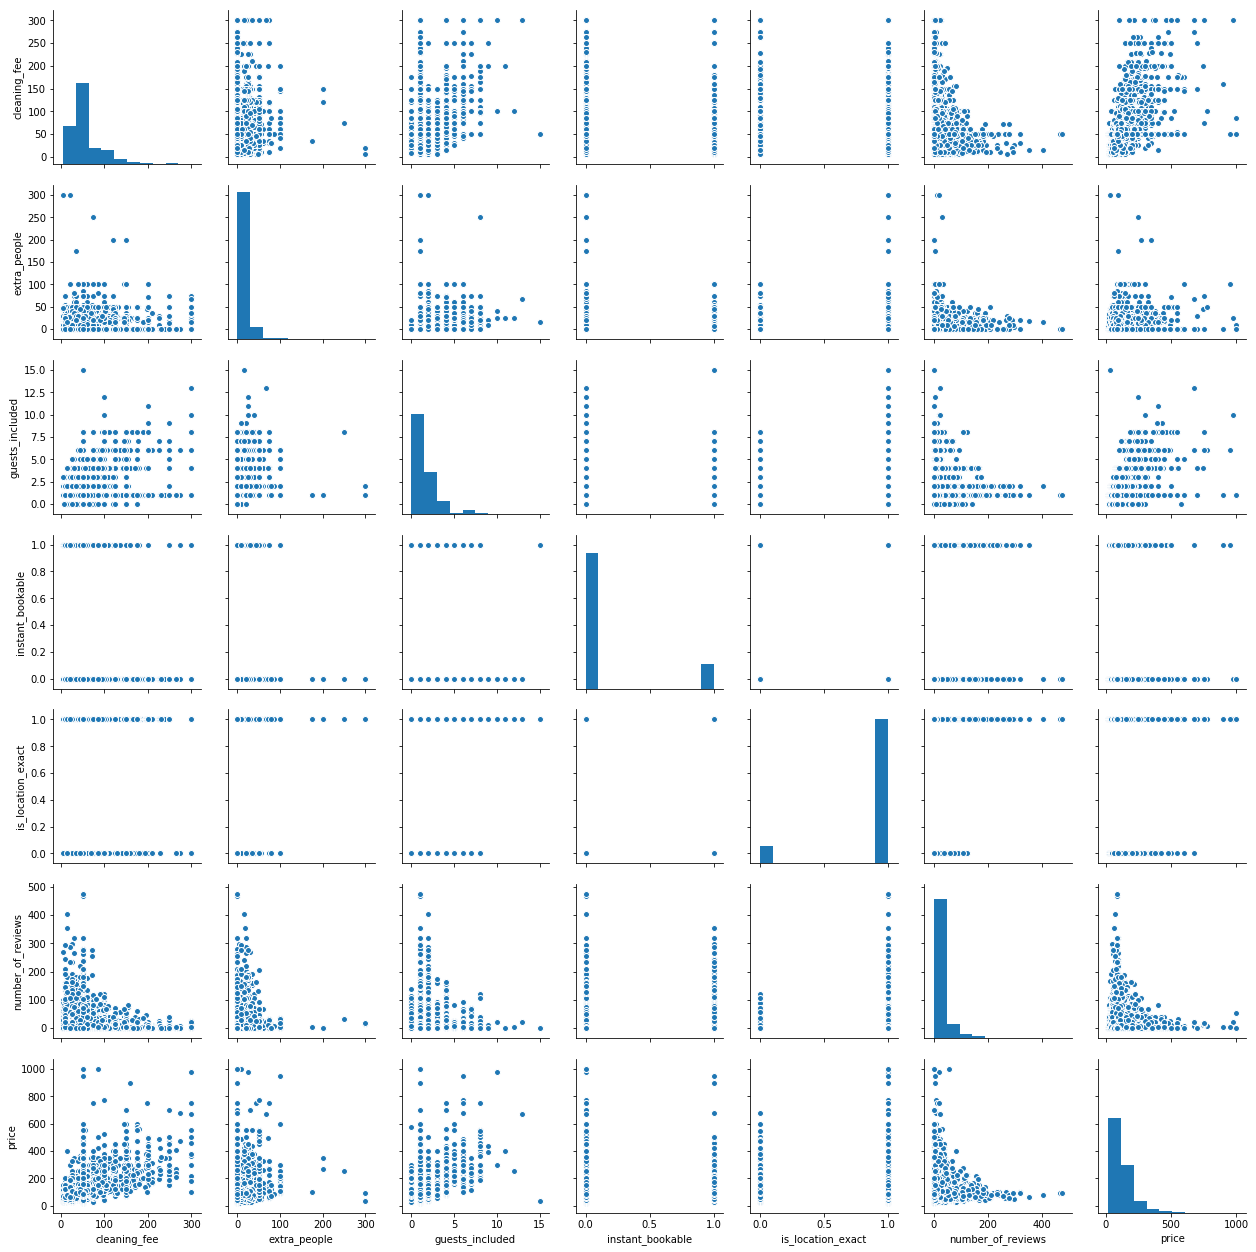

In [96]:
sales_info_list=['cleaning_fee',
 'extra_people',
 'guests_included',
 'instant_bookable',
 'is_location_exact',
 'number_of_reviews',
 'price' ]
sns.pairplot(clean_listings[sales_info_list]);    


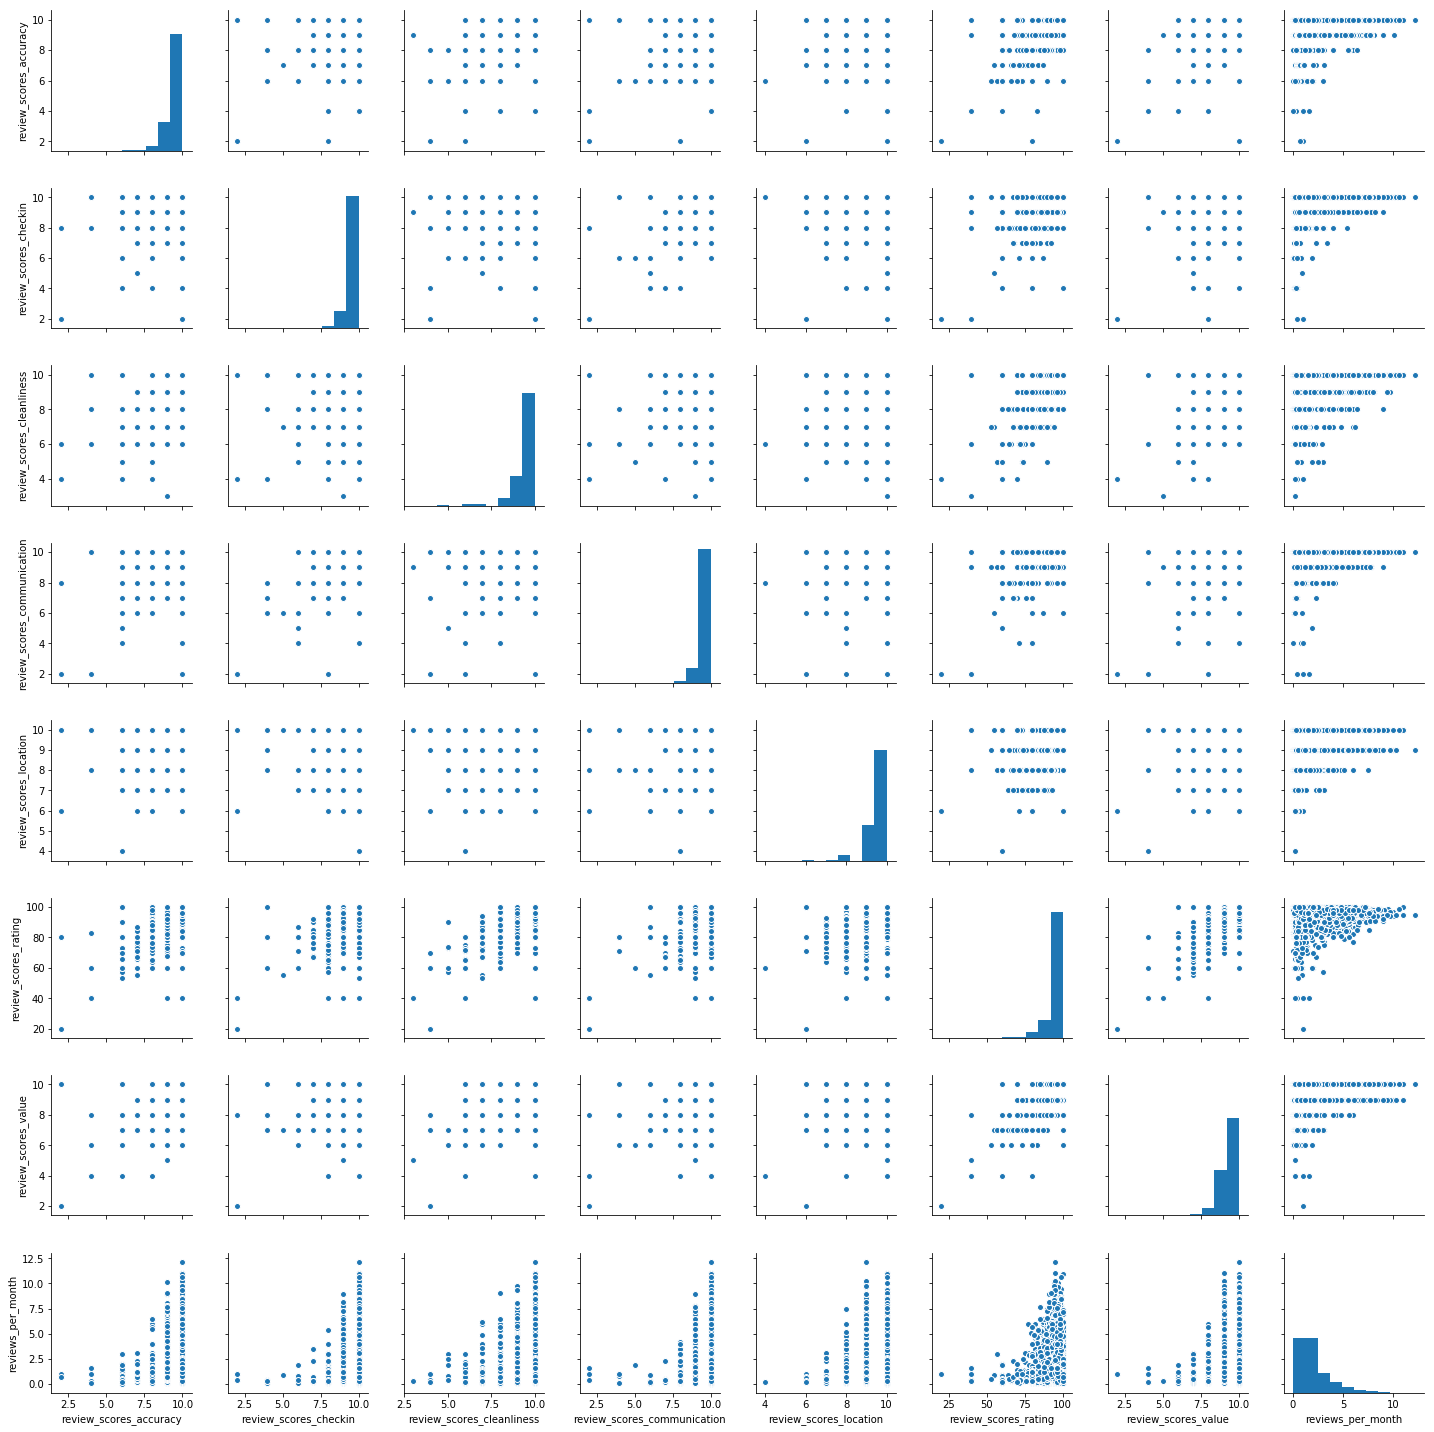

In [97]:
review_info_list=['review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month']
sns.pairplot(clean_listings[review_info_list]);   

price                        1.000000
accommodates                 0.652218
bedrooms                     0.627624
cleaning_fee                 0.598812
beds                         0.588989
bathrooms                    0.516009
guests_included              0.392875
amenities_length             0.165247
extra_people                 0.127961
host_total_listings_count    0.093879
Name: price, dtype: float64
review_scores_rating           1.000000
review_scores_value            0.688755
review_scores_cleanliness      0.642736
review_scores_accuracy         0.621557
review_scores_communication    0.545142
review_scores_checkin          0.525589
review_scores_location         0.377089
amenities_length               0.134682
host_response_rate             0.126267
reviews_per_month              0.074206
Name: review_scores_rating, dtype: float64


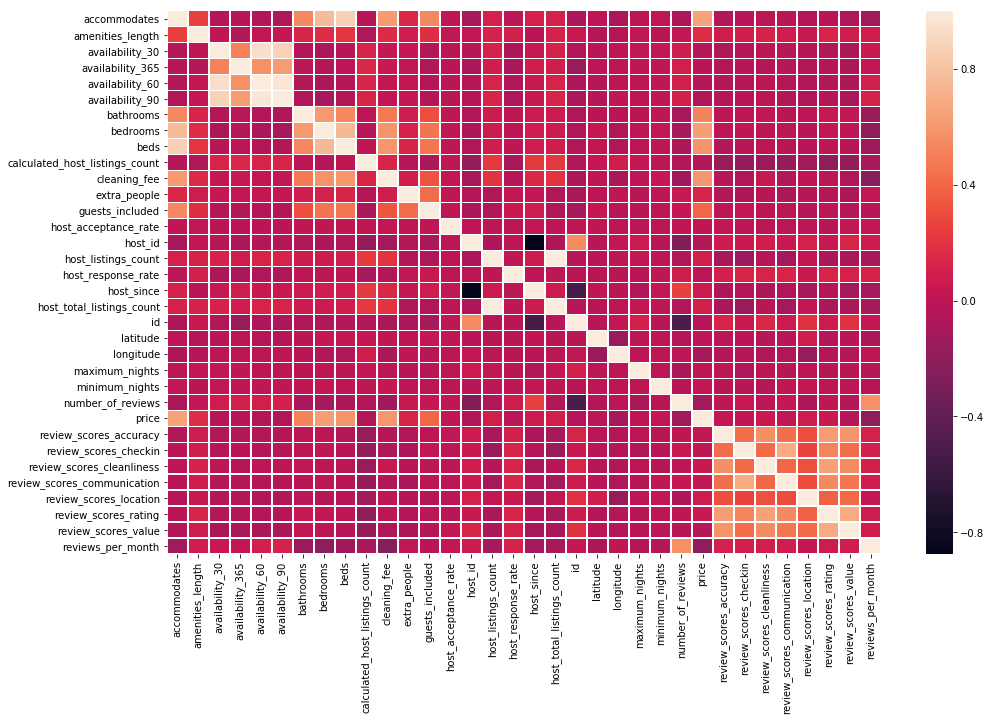

In [98]:
#Correlation Matrix
fig, ax = plt.subplots(figsize=(16,10))
corr = clean_listings[sorted(dtypes_l_dict['numeric'])].corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)
print(corr['price'].sort_values(ascending=False)[:10])
print(corr['review_scores_rating'].sort_values(ascending=False)[:10])

- the ratings subscore tend to correlate with the overall rating, and the biggest correlates except rating so far with review_score_rating appear to be:
  - host_response_rate
- Location ratings doesn't really seem to factor into the overall rating
- Price/Cleaning fee look like they're greatly influenced by size elements (bathrooms, beds, guests, etc.)
- avaiability 30,60,90,365 are highly correlation.

In [99]:
#Make columns type clean that only inlcude basic type
get_base_info(clean_listings)

The dataset contains 3818 rows and 117 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 117 entries, medium_url to reviews_per_month
dtypes: bool(7), float64(34), uint8(76)
memory usage: 1.3 MB

colum number is too large. Transpose the columns to show 3 rows
117
                                                        0            1  \
medium_url                                          False         True   
instant_bookable                                    False        False   
thumbnail_url                                       False         True   
require_guest_phone_verification                    False         True   
host_identity_verified                               True         True   
host_is_superhost                                   False         True   
is_location_exact                                    True         True   
cancellation_policy_flexible                            0            0   
cancellation_policy_moderate

### Question 1: how can we get high housing rent?
#### 1 Prepare data

In [109]:
q1_calendar=clean_calendar.copy()
q1_listings=listings.copy()
#q1_calendar['date']=pd.to_datetime(q1_calendar['date'])
q1_calendar['month']=q1_calendar['date'].apply(lambda x: x.month)
select_col_list=["id","property_type",'neighbourhood_group_cleansed','zipcode']
q1=pd.merge(q1_calendar,q1_listings[select_col_list],left_on="listing_id",right_on="id",how="left")
q1["weekday"] = q1["date"].dt.weekday

In [110]:
get_base_info(q1)

The dataset contains 1393570 rows and 10 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 10 columns):
price                           1393570 non-null float64
date                            1393570 non-null datetime64[ns]
available                       1393570 non-null bool
listing_id                      1393570 non-null int64
month                           1393570 non-null int64
id                              1393570 non-null int64
property_type                   1393205 non-null object
neighbourhood_group_cleansed    1393570 non-null object
zipcode                         1391015 non-null object
weekday                         1393570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 107.6+ MB

Show the dataset example:
   price       date  available  listing_id  month      id property_type  \
0   85.0 2016-01-04       True      241032      1  241032     Apartment   
1   8

In [111]:
q1_price = q1[q1["available"]]
q1_price.head()

,price,date,available,listing_id,month,id,property_type,neighbourhood_group_cleansed,zipcode,weekday
0,85.0,2016-01-04,True,241032,1,241032,Apartment,Queen Anne,98119,0
1,85.0,2016-01-05,True,241032,1,241032,Apartment,Queen Anne,98119,1
9,85.0,2016-01-13,True,241032,1,241032,Apartment,Queen Anne,98119,2
10,85.0,2016-01-14,True,241032,1,241032,Apartment,Queen Anne,98119,3
14,85.0,2016-01-18,True,241032,1,241032,Apartment,Queen Anne,98119,0


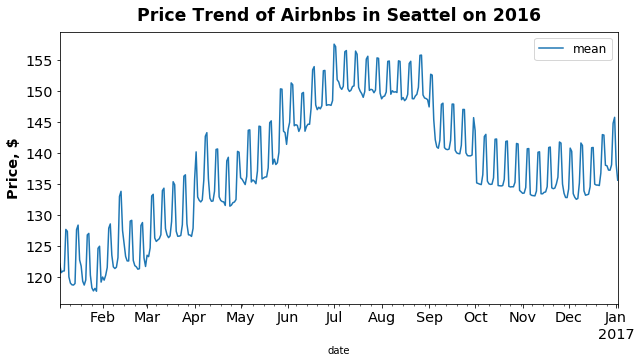

In [112]:
# Get the average rent price benchmark
fig,ax = plt.subplots(figsize=(10,5))
q1_price.groupby("date")["price"].agg(["mean"]).plot(ax=ax,grid=False,fontsize="x-large");
ax.legend(fontsize="large")
ax.set_ylabel("Price, $", fontsize="x-large",fontweight="bold")
plt.title("Price Trend of Airbnbs in Seattel on 2016",fontsize="xx-large",fontweight="bold",y=1.02);

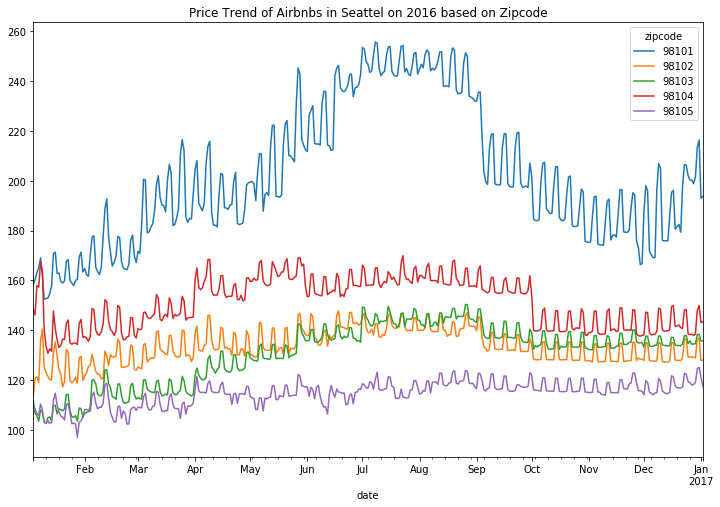

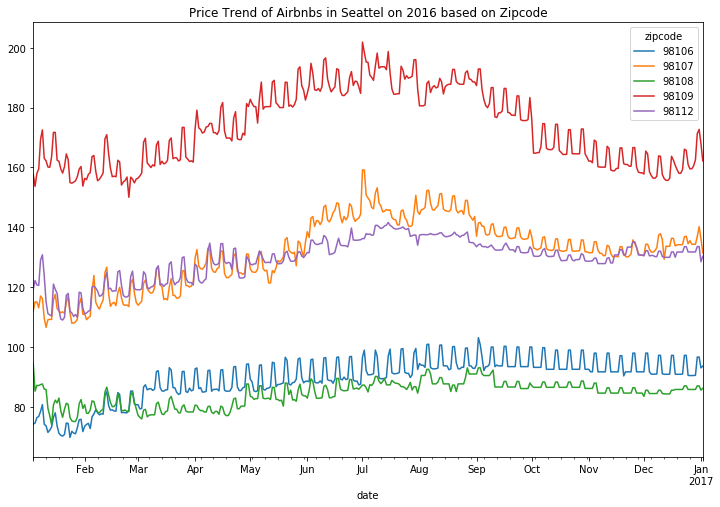

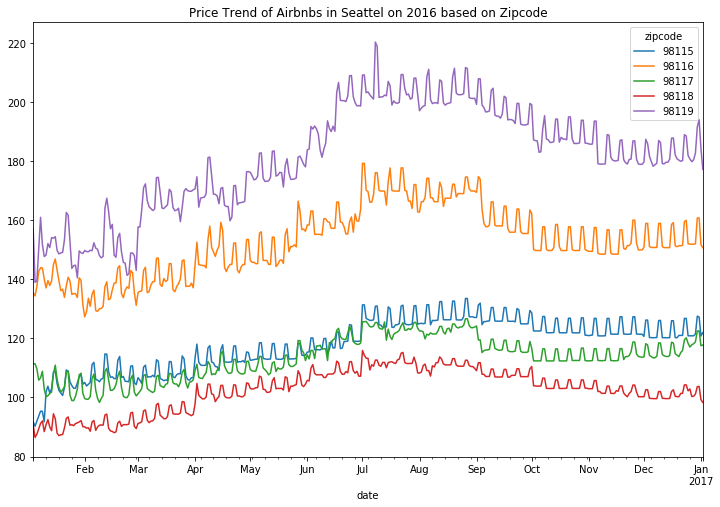

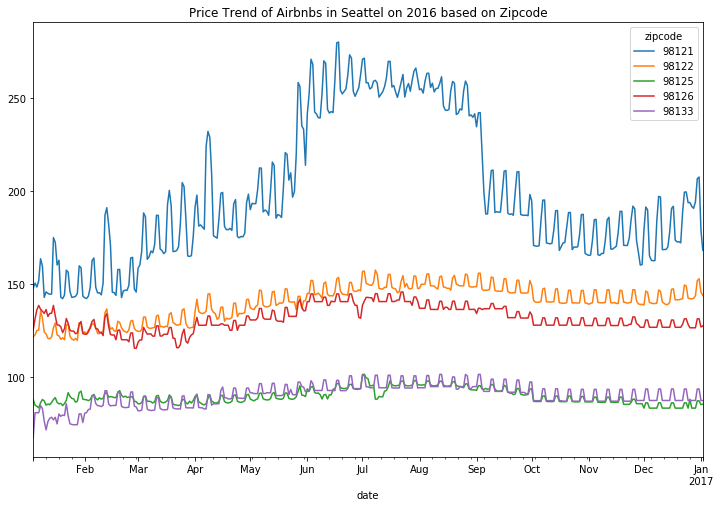

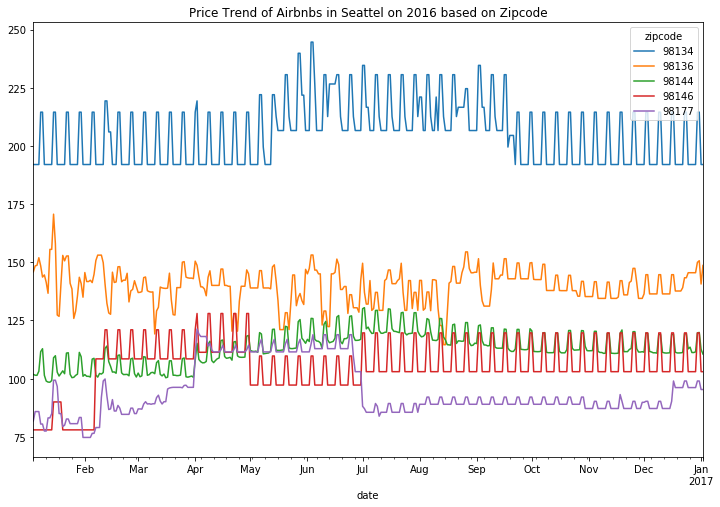

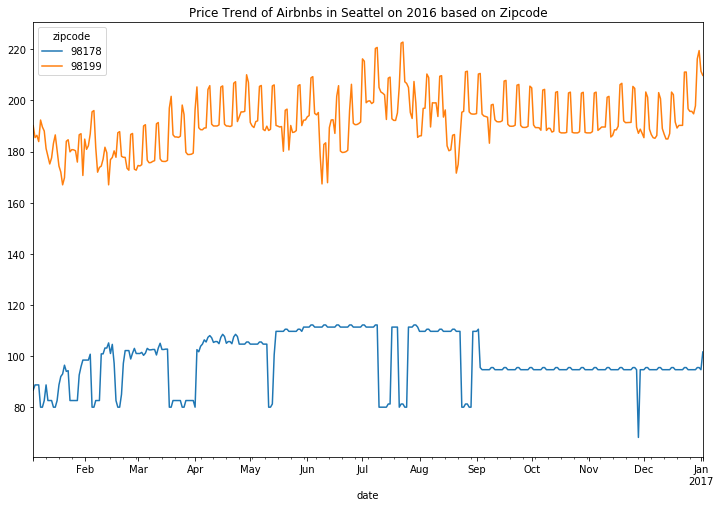

In [118]:
a = q1_price.groupby(["date","zipcode"])["price"].mean().unstack()
ax.set_xlabel("")
ax.set_ylabel("Price, $", fontsize="x-large",fontweight="bold")
ax.grid(False)
for col in a.columns:
    a[col].dropna(inplace=True)
for i in range(0,a.shape[1],5):
    j=i+5
    if j > a.shape[1]:
        j =a.shape[1]-1
    a.iloc[:,i:j].plot(figsize=(12,8),title="Price Trend of Airbnbs in Seattel on 2016 based on Zipcode") 


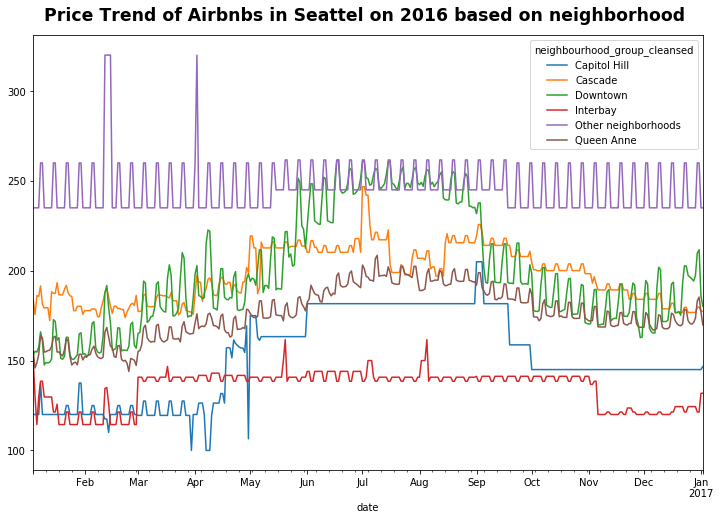

In [123]:
#analyze the above figure and select zipcode as follows:
select_zipcode=['98101','98121','98119','98134','98109']

# analyze the neighborhood based on select_zipcode:
a = q1_price.loc[q1_price.zipcode.isin(select_zipcode),:].groupby(["date","neighbourhood_group_cleansed"])["price"].mean().unstack()

for col in a.columns:
    a[col].dropna() 

a.plot(figsize=(12,8))

ax.set_xlabel("")
ax.set_ylabel("Price, $", fontsize="x-large",fontweight="bold")
ax.grid(False)

plt.title("Price Trend of Airbnbs in Seattel on 2016 based on neighborhood ",fontsize="xx-large",fontweight="bold",y=1.02);

In [124]:
# Analyze the special neighborhoods
select_cols=['price','neighbourhood_group_cleansed','number_of_reviews','reviews_per_month']
q11=listings.loc[listings.zipcode.isin(select_zipcode),select_cols]
q11.groupby('neighbourhood_group_cleansed')
q11[q11['neighbourhood_group_cleansed'].isin(['Interbay','Capitol Hill','Other neighborhoods'])]

,price,neighbourhood_group_cleansed,number_of_reviews,reviews_per_month
1911,$53.00,Interbay,26,4.36
1915,$69.00,Interbay,3,3.00
1916,$250.00,Interbay,0,NaN
1918,$50.00,Interbay,1,1.00
1920,$150.00,Interbay,22,1.15
1924,$265.00,Other neighborhoods,0,NaN
1925,$320.00,Other neighborhoods,2,0.12
1926,$150.00,Other neighborhoods,49,1.86
2809,$139.00,Capitol Hill,4,0.34
2836,$100.00,Capitol Hill,4,2.93


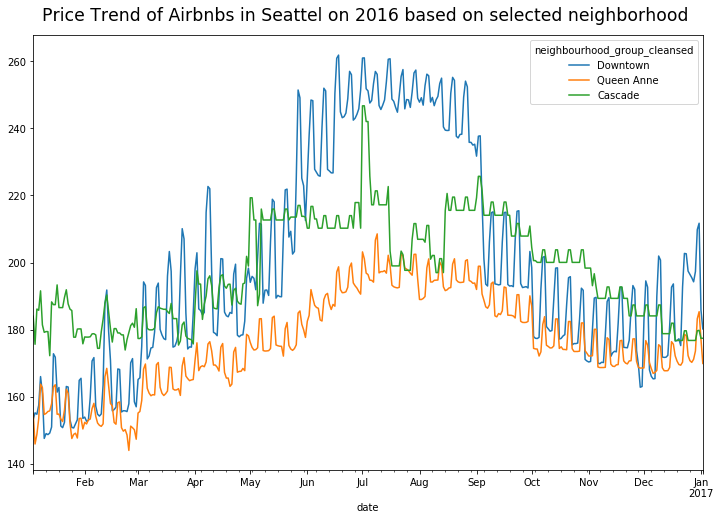

In [127]:
# according to previous step, we can find that 'Interbay','Capitol Hill','Other neighborhoods' have few records.
# so we can skip them. then we can select neighborhoods as follows:
select_neighbourhood=['Downtown','Queen Anne','Cascade']
a[select_neighbourhood].plot(figsize=(12,8))
plt.title("Price Trend of Airbnbs in Seattel on 2016 based on selected neighborhood ",fontsize="xx-large",y=1.02);

The number of missing value of property_type columns is:1 
The property_type columns type is:object 


House          0.453903
Apartment      0.447355
Townhouse      0.030906
Condominium    0.023834
Loft           0.010477
Name: property_type, dtype: float64

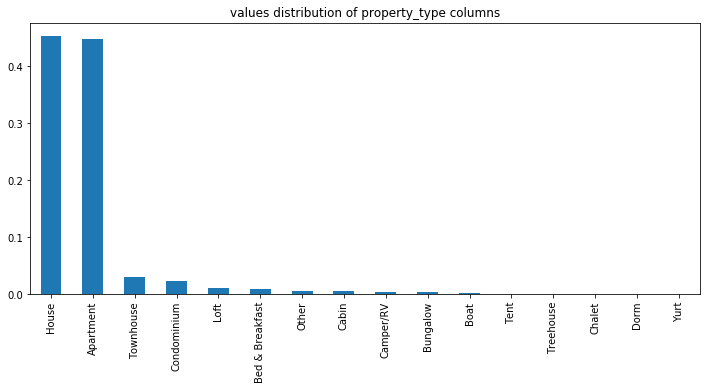

In [151]:
# analyze property type to find out which one should be selected.
assess_nonnumeric(listings, 'property_type')
pt_df=listings['property_type'].value_counts()[:5]/listings['property_type'].shape[0]
pt_df

In [131]:
condition1 = listings.zipcode.isin(select_zipcode)
condition2 = q1_price.neighbourhood_group_cleansed. isin(select_neighbourhood)
condition = condition1 & condition2

select_cols=['price','neighbourhood_group_cleansed','number_of_reviews','reviews_per_month','property_type']
q11=listings.loc[condition,select_cols]
q11.groupby('property_type')
q11[q11['property_type'].isin(['Dorm','Condominum','Bed & Breakfast'])]
q11['property_type'].value_counts()

Apartment          430
House               83
Condominium         38
Townhouse           11
Loft                 7
Other                5
Boat                 4
Bungalow             3
Camper/RV            3
Dorm                 2
Bed & Breakfast      1
Name: property_type, dtype: int64

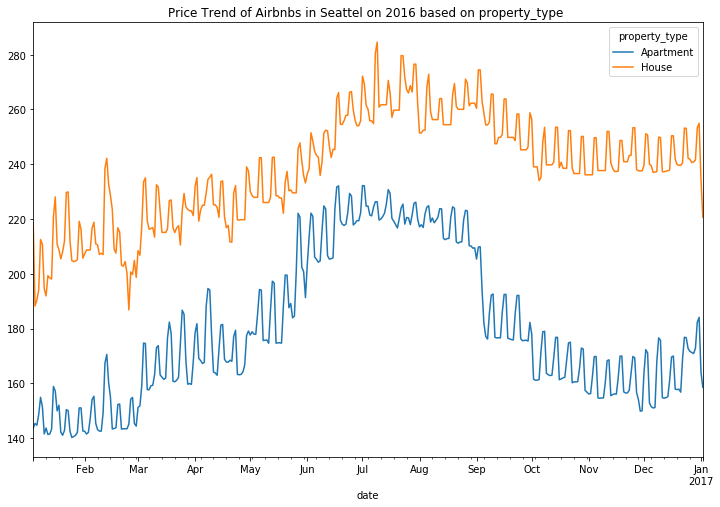

In [130]:
# base on above two steps, we can find that house type should be apartments and houses.
condition1 = q1_price.zipcode.isin(select_zipcode)
condition2 = q1_price.neighbourhood_group_cleansed. isin(select_neighbourhood)
condition = condition1&condition2
a = q1_price.loc[condition,:].groupby(["date","property_type"])["price"].mean().unstack()
ax.set_xlabel("")
ax.set_ylabel("Price, $", fontsize="x-large",fontweight="bold")
ax.grid(False)

for col in a.columns.values.tolist():
    a[col].dropna(inplace=True)
house_type=['Apartment','House'] 
a[house_type].plot(figsize=(12,8),title="Price Trend of Airbnbs in Seattel on 2016 based on property_type ")


### Question 2: how to improve the occupancy rate?

#### Modeling

In [168]:
y = clean_listings['reviews_per_month']
x = clean_listings.drop('reviews_per_month', axis =1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)

fr = RandomForestRegressor(n_estimators=500, criterion='mse',random_state=3,n_jobs=-1)
fr.fit(X_train, y_train)
y_train_pred = fr.predict(X_train)
y_test_pred = fr.predict(X_test)

#### Evaluation

In [169]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.037, test: 0.344
R^2 train: 0.987, test: 0.884


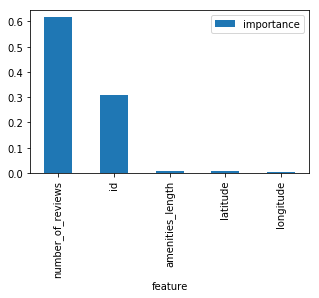

In [170]:
#Look at outputs
importances = fr.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:5].plot(x='feature', y='importance', kind='bar',figsize=(5,3))

The occupation rate is positive correlation with reviews_per_month.
 - number_of_reviews: number_of_reviews has a great impact on reviews_per_month. Incentives are needed to motivate customers to review the accommodation.
 - id is listings id. The listings ID is strongly related to the years provided by the host. So the longer you provide accommodation on Airbnb, the more people live your house and the more reviews you make each month.
 - amenities_lenght: it converts from amenities. the more services the host provides, the greater the impact on the number of monthly reviews. The amenities will be analyzed later.
 - latitude, longitude: they are location information. The previous neighborhood analysis also provides the same information and select target neighborhoods. Good location, more customer check-in, more reviews per month.


### Question3: how to save costs?

#### Modeling

In [178]:
y = clean_listings['price']
x = clean_listings.drop('price', axis =1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)

fr1 = RandomForestRegressor(n_estimators=500, criterion='mse',random_state=3,n_jobs=-1)
fr1.fit(X_train, y_train)
y_train_pred = fr1.predict(X_train)
y_test_pred = fr1.predict(X_test)

#### Evaluation

In [179]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 435.237, test: 3017.299
R^2 train: 0.948, test: 0.607


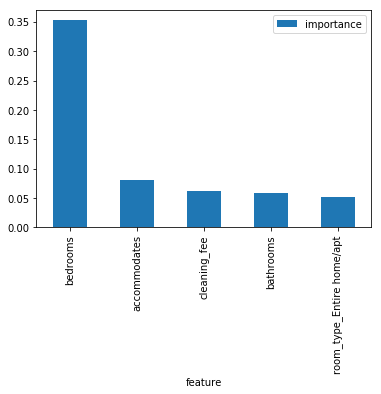

In [180]:
#Look at outputs
importances = fr1.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:5].plot(x='feature', y='importance', kind='bar')

The main features related with cost are bedrooms and accommodates in above figure. Futher analyzing features correlation in listings data set, we can known the typical composition of the room and the the number of accomodate

In [133]:
condition3 = listings.property_type.isin(house_type)
condition = condition&condition3
room_type =['accommodates','bathrooms','bedrooms','beds' ]
select_cols_list=select_cols +room_type 
q11=listings.loc[condition,select_cols_list]
q11.head()

,price,neighbourhood_group_cleansed,number_of_reviews,reviews_per_month,property_type,accommodates,bathrooms,bedrooms,beds
0,$85.00,Queen Anne,207,4.07,Apartment,4,1.0,1.0,1.0
1,$150.00,Queen Anne,43,1.48,Apartment,4,1.0,1.0,1.0
9,$150.00,Queen Anne,32,1.55,Apartment,4,1.0,1.0,1.0
10,$95.00,Queen Anne,181,3.33,House,2,1.0,1.0,1.0
14,$461.00,Queen Anne,18,2.65,House,16,3.5,6.0,15.0


In [139]:
# get the most use value of room type
q111=q11.groupby('property_type')
print(q111[room_type].mean())
typical_room_type= q111[room_type].agg(pd.Series.mode).reset_index()
typical_room_type

               accommodates  bathrooms  bedrooms      beds
property_type                                             
Apartment          3.397674   1.177570  1.072430  1.667442
House              4.481928   1.638554  2.024096  2.409639


,property_type,accommodates,bathrooms,bedrooms,beds
0,Apartment,2,1.0,1.0,1.0
1,House,2,1.0,1.0,1.0


#### Analyze amenities

In [181]:
#creating a dictionary of each amenities and the count value
from collections import Counter
amenities_tmp_list=[]
for i in listings.amenities.tolist():
    tmp=i.replace('\"','')
    tmp=tmp.replace('{','')
    tmp=tmp.replace('}','')
    amenities_tmp_list.append(tmp.split(','))
amenities_list = []
for i in amenities_tmp_list:
    for j in i:
        amenities_list.append(j)
amenities_count = Counter(amenities_list)
amenities_count_dict = dict(amenities_count)

In [182]:
#creating a dataframe with amenities and the number of houses providing the amenities
count_dict = {'amenities_available': list(amenities_count_dict.keys()), 'num_amenities': list(amenities_count_dict.values())}
amenities_count_df = pd.DataFrame.from_dict(count_dict)
amenities_count_df[amenities_count_df['amenities_available'] == ''] = np.nan
amenities_count_df.sort_values(by = 'num_amenities', ascending = False,inplace=True)
amenities_count_df.dropna(inplace=True)
amenities_count_df.head(10)

,amenities_available,num_amenities
25,Wireless Internet,3667.0
27,Heating,3627.0
11,Kitchen,3423.0
29,Smoke Detector,3281.0
40,Essentials,3237.0
39,Dryer,2997.0
6,Washer,2992.0
35,Internet,2811.0
9,Shampoo,2670.0
38,TV,2574.0


#### Get the reviews_per_month counts comparsion with on/off amenities.

In [186]:
wifi_flag=lambda x:("Wireless Internet" in x)
heating_flag=lambda x:("Heating" in x)
kitchen_flag=lambda x:("Kitchen" in x)
smoke_flag=lambda x:("Smoke Detector" in x)
essentials_flag=lambda x:("Essentials" in x)
dryer_flag=lambda x:("Dryer" in x)

clean_listings['wifi_flag']=listings['amenities'].apply(wifi_flag)
clean_listings['heating_flag']=listings['amenities'].apply(heating_flag)
clean_listings['kitchen_flag']=listings['amenities'].apply(kitchen_flag)
clean_listings['smoke_flag']=listings['amenities'].apply(smoke_flag)
clean_listings['essentials_flag']=listings['amenities'].apply(essentials_flag)
clean_listings['dryer_flag']=listings['amenities'].apply(dryer_flag)

In [187]:
flag_cols=clean_listings.loc[:,'wifi_flag':'dryer_flag'].columns.values.tolist()
#flag_cols=clean_listings.loc[:,'wifi_flag':'dryer_flag'].columns.values.tolist()
target=None
for col in flag_cols:
    tmp=clean_listings.groupby(col)['reviews_per_month'].mean().reset_index()
    tmp=tmp.rename(columns={'wifi_flag':'flag_index','reviews_per_month':col+'_count'})
    if target is None:
        target=tmp
    else:
        tmp.drop(col, axis=1, inplace=True)
        target=pd.concat([target,tmp],axis=1)

In [188]:
target=target.set_index('flag_index')
target

,wifi_flag_count,heating_flag_count,kitchen_flag_count,smoke_flag_count,essentials_flag_count,dryer_flag_count
flag_index,,,,,,
False,1.555430,1.593089,2.534228,1.558250,1.356454,2.239716
True,2.008328,2.011340,1.927663,2.061149,2.104205,1.934056


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014A0ADD8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000014D46358>]], dtype=object)

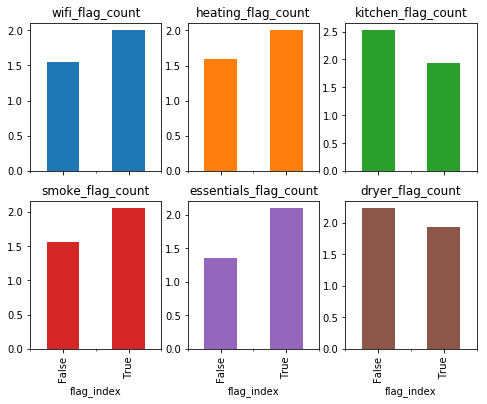

In [189]:
target.plot.bar(subplots=True,figsize=(8,6),legend=False,layout=(2,3))

We can know that WIFI internet plays important role in customers' select room. Hosts who provide WIFI get their property booked a lot more than those who don't. And customers tend to book properties without kitchen and dryer. Aparments with heating , smoke detector and essentials tend to get more booking as well. Probably in the US, heating is important if customers travel to Seattle in winter.
  

## Conclusion

If we want to earn more as Airbnb host in Seattle, we should invest house or apartment in Downtown, Queen Anne and Cascade. And the houses or apartments has typical configuration with 2 accommodates,1 bathrooms	bedrooms, 1 beds.  In order to increase the occupancy rate, Incentives are needed to motivate customers to review the accommodation. We should provide more suitable amenities. But in order to save costs, some amenities that slightly affect the occupancy rate are removed, leaving only: Wireless Internet, Heating, Smoke Detector, Essentials and other basic amenities to reduce costs. When you do these jobs, you may get a higher income.

# Seattle Airbnb dataset analysis project

## 1. Installation
I use python 3.5 to create this project and the libraries I used are:
 - Pandas
 - Numpy
 - Matplotlib
 - Collections
 - Seaborn
 - Scikit-Learn
 
## 2. Project Motivation
If an investor wants to invest in a house as an Airbnb host in Seattle, how will the investor get a higher income?  In this project, I'm going to answer these following questions:
  - how can we get high housing rent?
  - how to improve the occupancy rate?
  - how to save costs?
  
## 3. File Descriptions
  - AirBnB analysis.ipynb
      - This is the file that describes the data science process I used to answer the questions of this project. I use mechine learning to analyze the dataset.

  - The .csv files
       - These are the calendar and listings file from Seattle. The original source of these files is Kaggle.
           - https://www.kaggle.com/airbnb/seattle/activity


## 4. Summary of the results of the analysis

If we want to earn more as Airbnb host in Seattle, we should invest house or apartment in Downtown, Queen Anne and Cascade. And the houses or apartments has typical configuration with 2 accommodates,1 bathrooms	bedrooms, 1 beds.  In order to increase the occupancy rate, Incentives are needed to motivate customers to review the accommodation. We should provide more suitable amenities. But in order to save costs, some amenities that slightly affect the occupancy rate are removed, leaving only: Wireless Internet, Heating, Smoke Detector, Essentials and other basic amenities to reduce costs. When you do these jobs, you may get a higher income.

## 5. Licensing, Author, Acknowledgements
 - Code released under the MIT License. Docs released under Creative Commons.

 - Thanks for Kaggle's dataset.
 
 - Thanks for Fangzhong Feng's idea.
